# Bayes by Backprop
An implementation of the algorithm described in https://arxiv.org/abs/1505.05424.  
This notebook accompanies the article at https://www.nitarshan.com/bayes-by-backprop.

In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())

True


## Data Preparation

In [3]:
BATCH_SIZE = 100
TEST_BATCH_SIZE = 5

affine_transfomer = transforms.RandomAffine(degrees=(0, 360), scale=(0.65, 1.25))

composed_trans = transforms.Compose([
                    affine_transfomer,
                    transforms.ToTensor(),
                ])

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=True, download=True,
        transform=composed_trans),
    batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=False, download=True,
        transform=composed_trans),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 10
TRAIN_EPOCHS = 50
SAMPLES = 2
TEST_SAMPLES = 10

NAME = "BayesBackprop"

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

In [4]:
idx = 0
for img, label in train_loader:
    im = transforms.ToPILImage()(img[0]).convert("RGB")
    display(im)
    print(label[0])
    idx += 1
    if idx > 10:
        break

tensor(2)


tensor(8)


tensor(2)


tensor(2)


tensor(0)


tensor(3)


tensor(4)


tensor(4)


tensor(0)


tensor(9)


tensor(6)


## Modelling
$$\underline{\text{Reparameterized Gaussian}}$$
$$\begin{aligned}
\theta &= (\mu, \rho)\\
\sigma &= \ln{(1+e^\rho)}\\
\mathcal{N}(x\vert \mu, \sigma) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}\\
\ln{\mathcal{N}(x\vert \mu, \sigma)} &= -\ln{\sqrt{2\pi}} -\ln{\sigma} -\frac{(x-\mu)^2}{2\sigma^2}\\
P(\mathbf{w}) &= \prod_j{\mathcal{N}(\mathbf{w}_j \vert 0, \sigma^2)}\\
\ln{P(\mathbf{w})} &= \sum_j{\ln{\mathcal{N}(\mathbf{w}_j \vert 0, \sigma^2)}}\\
\end{aligned}$$

In [5]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho)).to(DEVICE)
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return torch.tensor(-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

$$\underline{\text{Scale Mixture Gaussian}}$$
$$\begin{align}
P(\mathbf{w}) &= \prod_j{\pi \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_1^2) + (1-\pi) \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_2^2)}\\
\ln{P(\mathbf{w})} &= \sum_j{\ln{(\pi \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_1^2) + (1-\pi) \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_2^2))}}\\
\end{align}$$

In [6]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = torch.tensor(pi).to(DEVICE)
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        # input = torch.tensor(input)
        prob1 = torch.exp(self.gaussian1.log_prob(input.cpu())).to(DEVICE)
        prob2 = torch.exp(self.gaussian2.log_prob(input.cpu())).to(DEVICE)
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

$$\pi = \frac{1}{2}$$
$$-\ln{\sigma_1} = 0$$
$$-\ln{\sigma_2} = 6$$

C:\Users\devas\AppData\Local\Temp\ipykernel_21776\1322020080.py:12: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  d1 = np.array([torch.exp(normal_1.log_prob(torch.tensor(c))).cpu() for c in x_points])
C:\Users\devas\AppData\Local\Temp\ipykernel_21776\1322020080.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  d1 = np.array([torch.exp(normal_1.log_prob(torch.tens

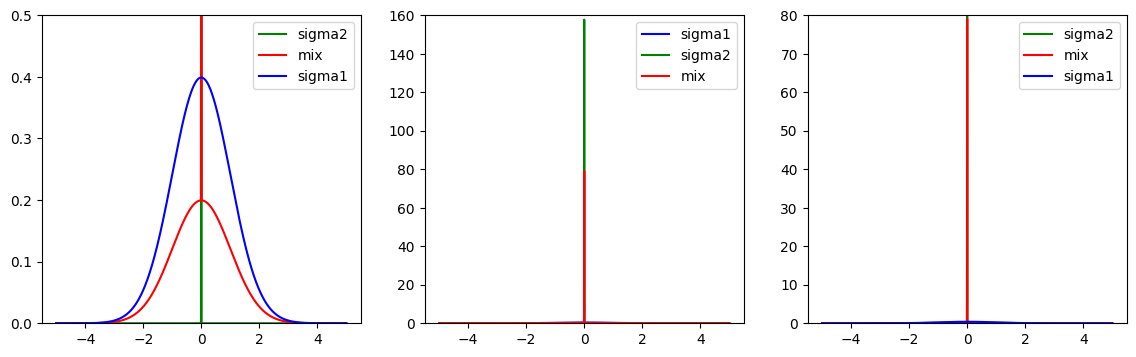

In [7]:
PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])

def visualize_scale_mixture_components():
    def show_lines():
        pass
    mix = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
    normal_1 = torch.distributions.Normal(0, SIGMA_1)
    normal_2 = torch.distributions.Normal(0, SIGMA_2)
    x_points = np.linspace(-5,5,10000)
    d1 = np.array([torch.exp(normal_1.log_prob(torch.tensor(c))).cpu() for c in x_points])
    d2 = np.array([torch.exp(normal_2.log_prob(torch.tensor(c))).cpu() for c in x_points])
    d3 = np.array([torch.exp(mix.log_prob(torch.tensor(c))).cpu() for c in x_points])
    plt.subplots(1,3,figsize=(14,4))
    plt.subplot(1,3,1)
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.plot(x_points,d1,color="b")
    plt.legend(["sigma2", "mix", "sigma1"])
    plt.ylim(0,0.5)
    plt.subplot(1,3,2)
    plt.plot(x_points,d1,color="b")
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.legend(["sigma1", "sigma2", "mix"])
    plt.ylim(0,160)
    plt.subplot(1,3,3)
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.plot(x_points,d1,color="b")
    plt.legend(["sigma2", "mix", "sigma1"])
    plt.ylim(0,80)
    
visualize_scale_mixture_components()

In [8]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0
        return F.linear(input, weight, bias)

In [9]:
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = BayesianLinear(28*28, 500).to(DEVICE)
        self.l2 = BayesianLinear(500, 500).to(DEVICE)
        self.l3 = BayesianLinear(500, 10).to(DEVICE)
    
    def forward(self, x, sample=False):
        x = x.view(-1, 28*28)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x = F.log_softmax(self.l3(x, sample), dim=1)
        return x
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior
    
    def sample_elbo(self, input, target, samples=SAMPLES):
        outputs = torch.zeros(samples, BATCH_SIZE, CLASSES).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        likelihood_cost = F.nll_loss(outputs.mean(0), target, size_average=False)
        data_cost = (log_variational_posterior - log_prior) 
        return data_cost, likelihood_cost

net = BayesianNetwork().to(DEVICE)

## Training

In [10]:
def save_training_viz(train_hist, epoch):
    plt.figure(figsize=(10,9))
    plt.plot(train_hist,'b', label="training loss")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(f'./{NAME}_{epoch}_training.png')

In [11]:
train_loss = []
def train(net, optimizer, epoch):
    net.train()
    pbar = tqdm(train_loader)
    running_wloss = 0
    running_tloss = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(DEVICE), target.to(DEVICE)
        net.zero_grad()
        data_cost, likelihood_cost = net.sample_elbo(data, target)
        pi = (2**(NUM_BATCHES-batch_idx))/(2**(NUM_BATCHES-1))
        wloss = pi*data_cost + likelihood_cost
        tloss = data_cost + likelihood_cost
        wloss.backward()
        optimizer.step()
        
        running_wloss += wloss
        running_tloss += tloss
        pbar.set_description(f"Epoch {epoch} | Weighted loss = {round(float(running_wloss/len(train_loader)),3):.3f} | Total loss {round(float(running_tloss/len(train_loader)),3):.3f} | ")
    train_loss.append(float(running_tloss/len(train_loader)))
    save_training_viz(train_loss,epoch+1)
    torch.save(net, f'{NAME}_{epoch}_{round(float(running_tloss/len(train_loader)),3)}.pth')


  0%|          | 0/600 [00:00<?, ?it/s]C:\Users\devas\AppData\Local\Temp\ipykernel_21776\4074216212.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(-math.log(math.sqrt(2 * math.pi))
c:\Users\devas\miniconda3\envs\superres\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Epoch 0 | Weighted loss = 19761.652 | Total loss 2930010.000 | : 100%|██████████| 600/600 [01:35<00:00,  6.27it/s]
Epoch 1 | Weighted loss = 19663.201 | Total loss 2918416.750 | : 100%|██████████| 600/600 [01:23<00:00,  7.15it/s]
Epoch 2 | Weighted loss = 19572.375 | Total loss 2905952.500 | : 100%|██████████| 600/600 [01:21<00:00,  7.36it/s]
Epoch 3 | Weighted loss = 19476.574 | Total loss 2893275.000 | : 100%|██████

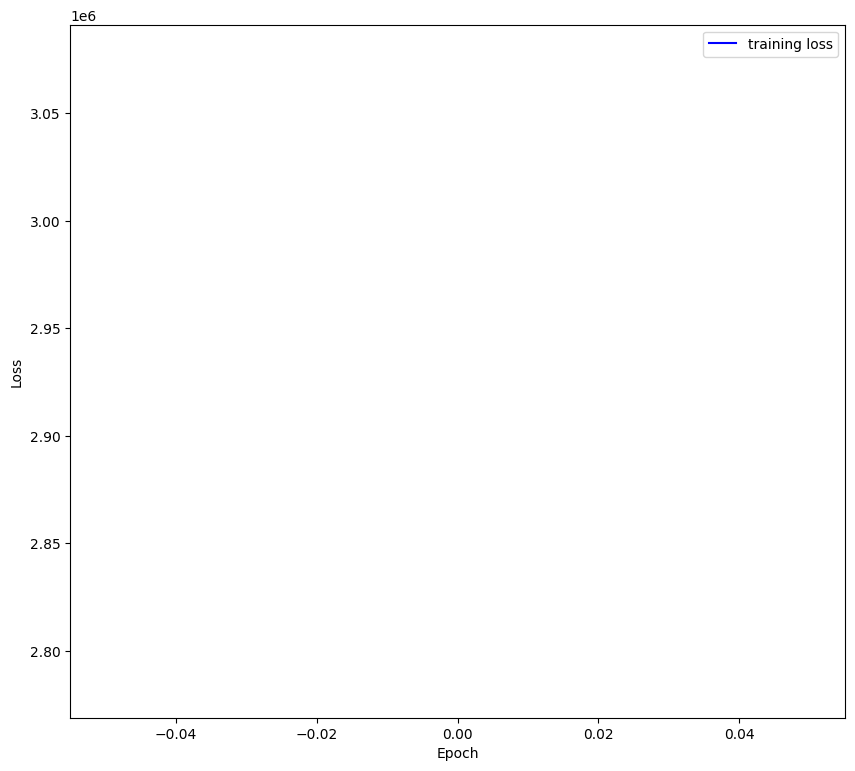

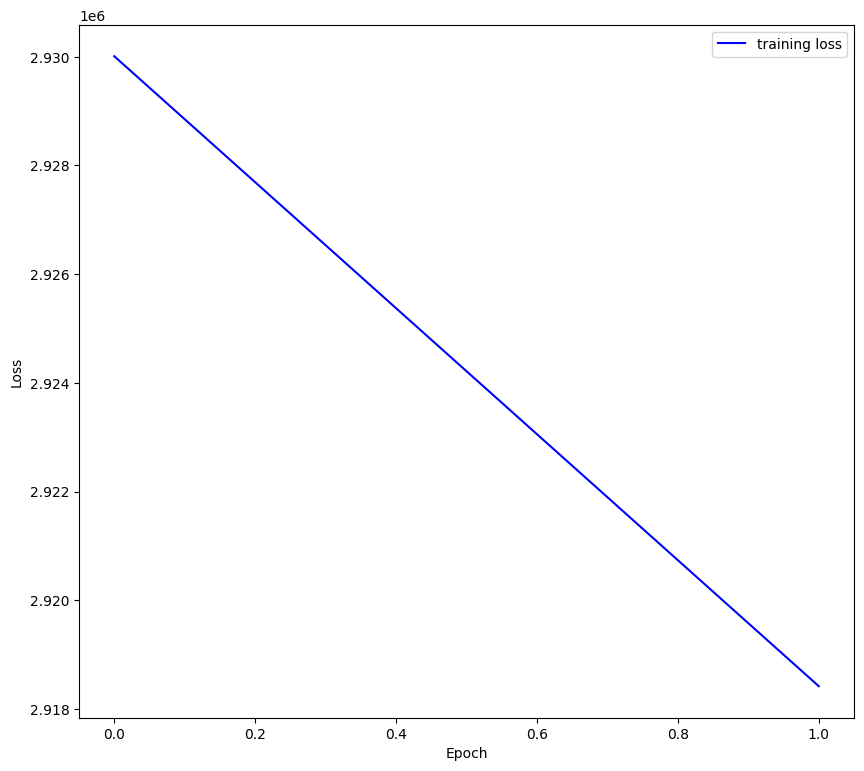

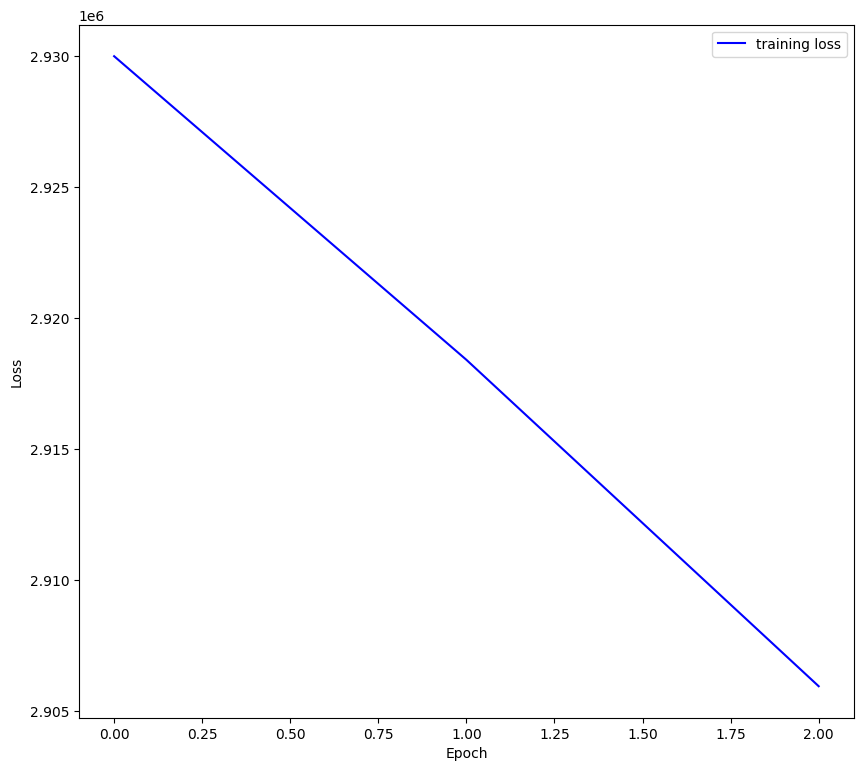

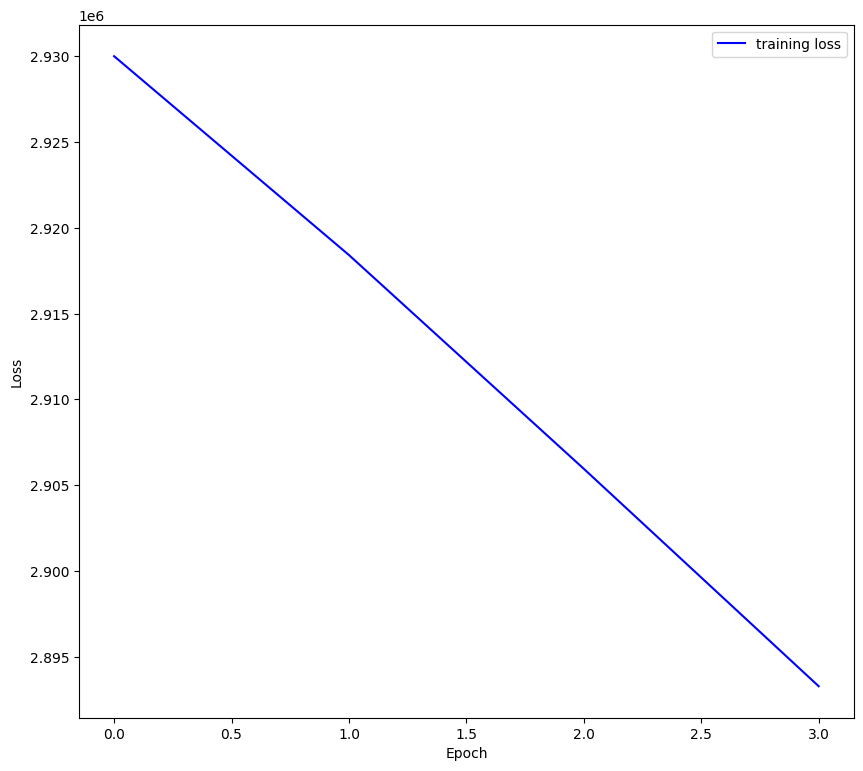

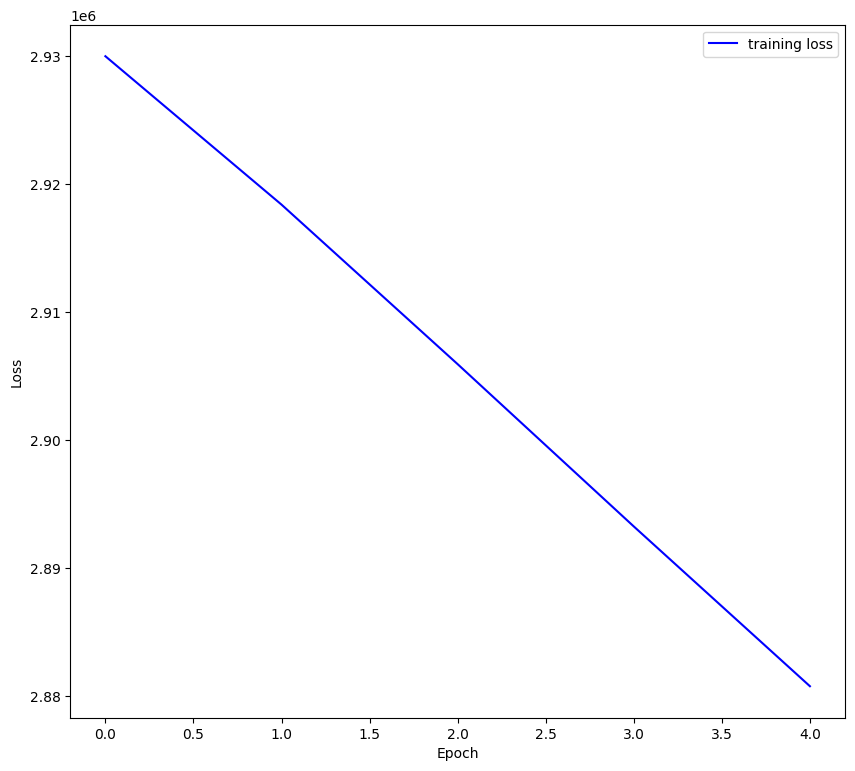

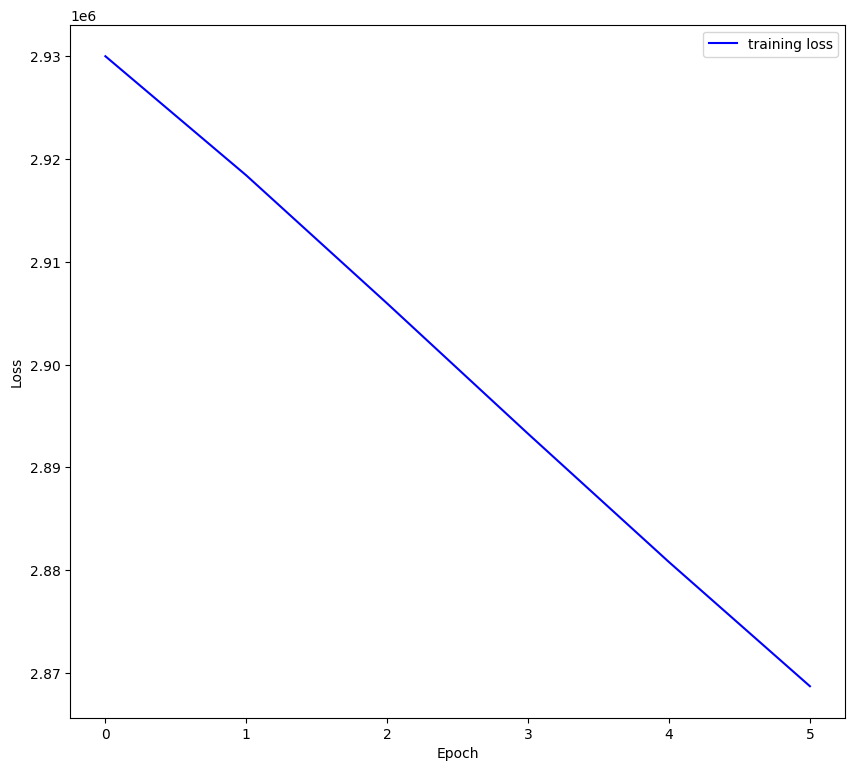

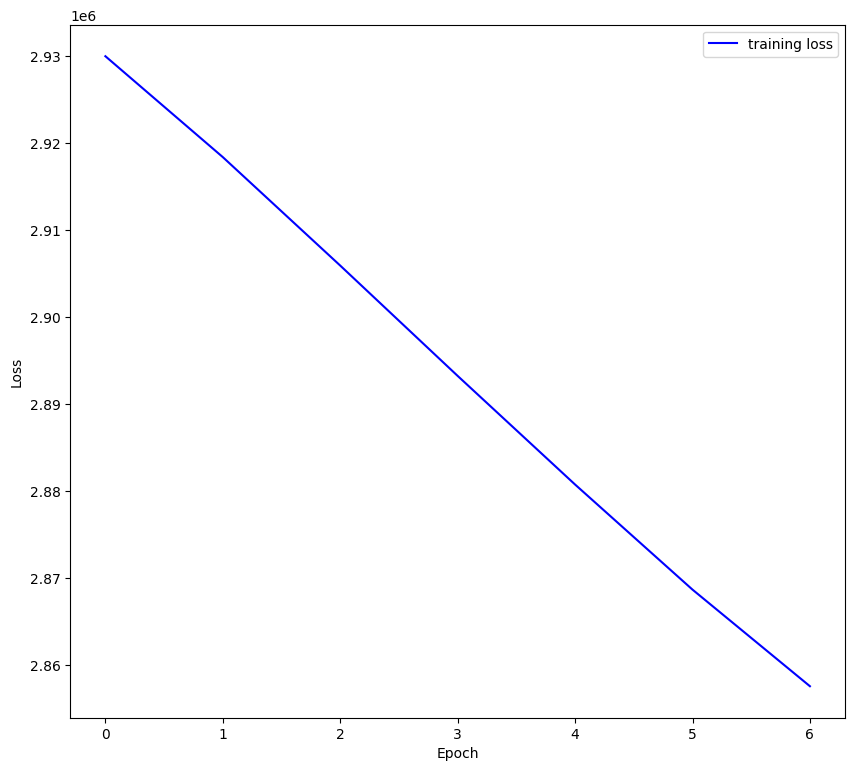

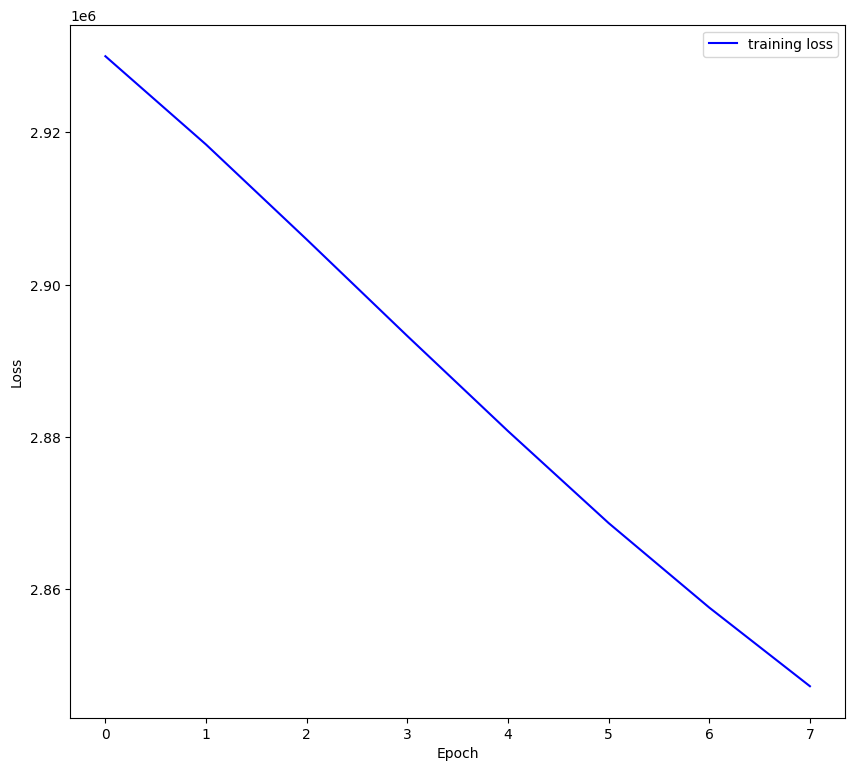

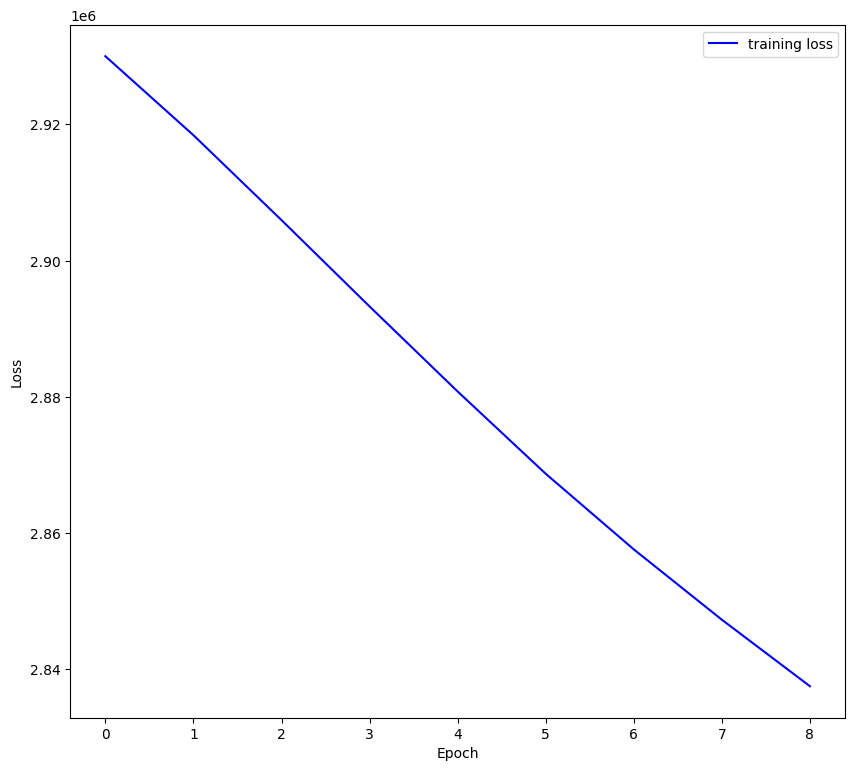

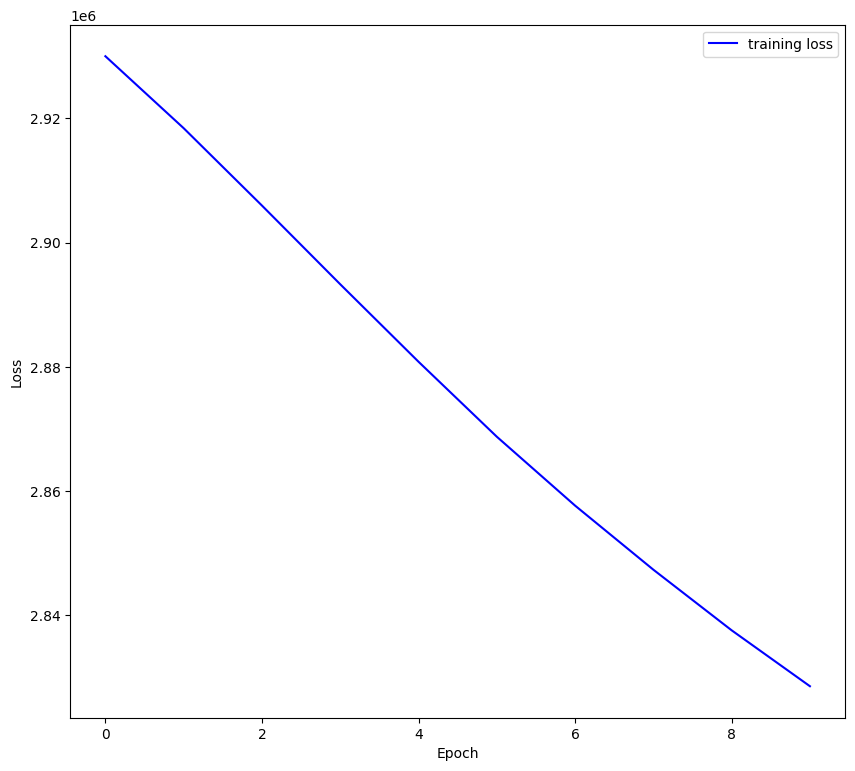

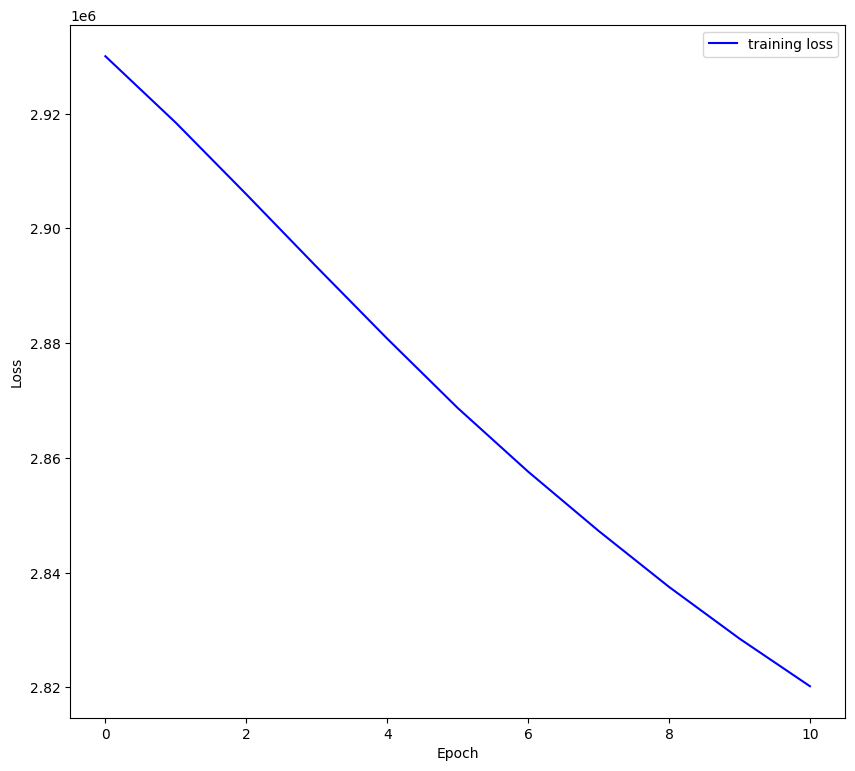

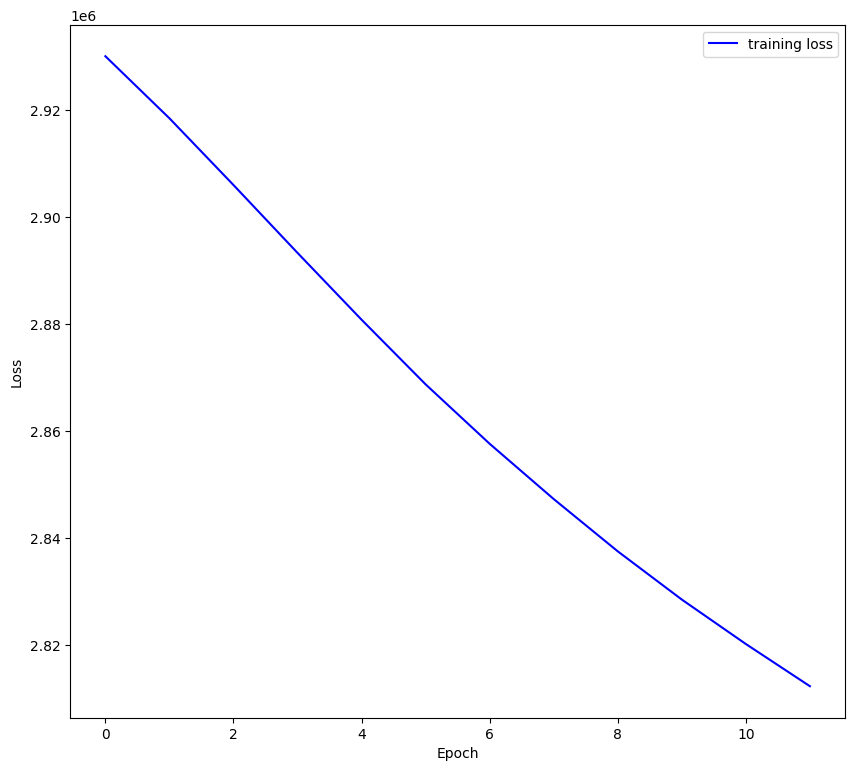

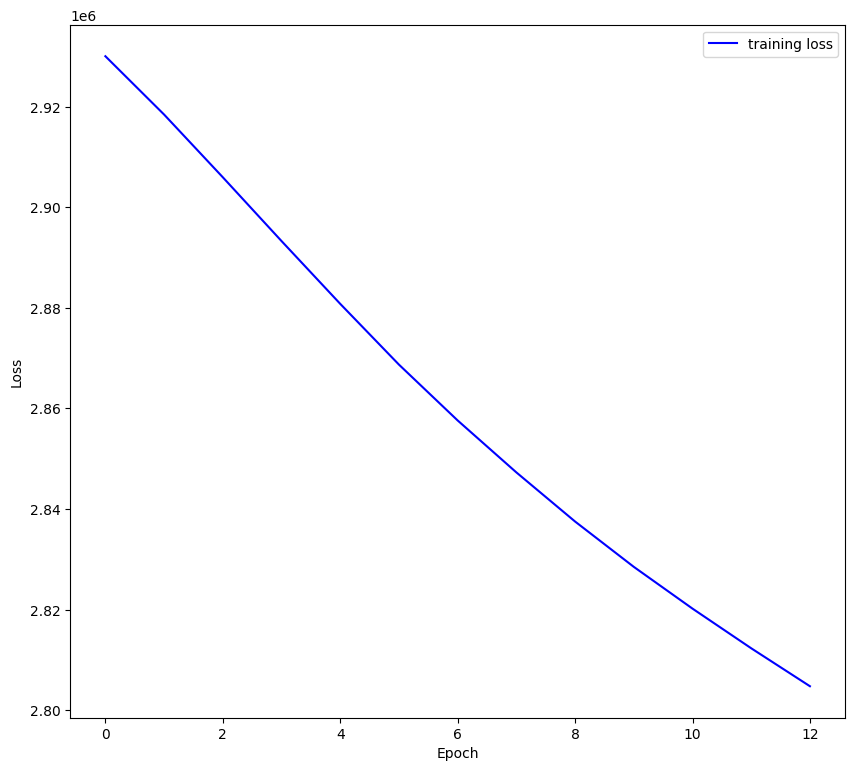

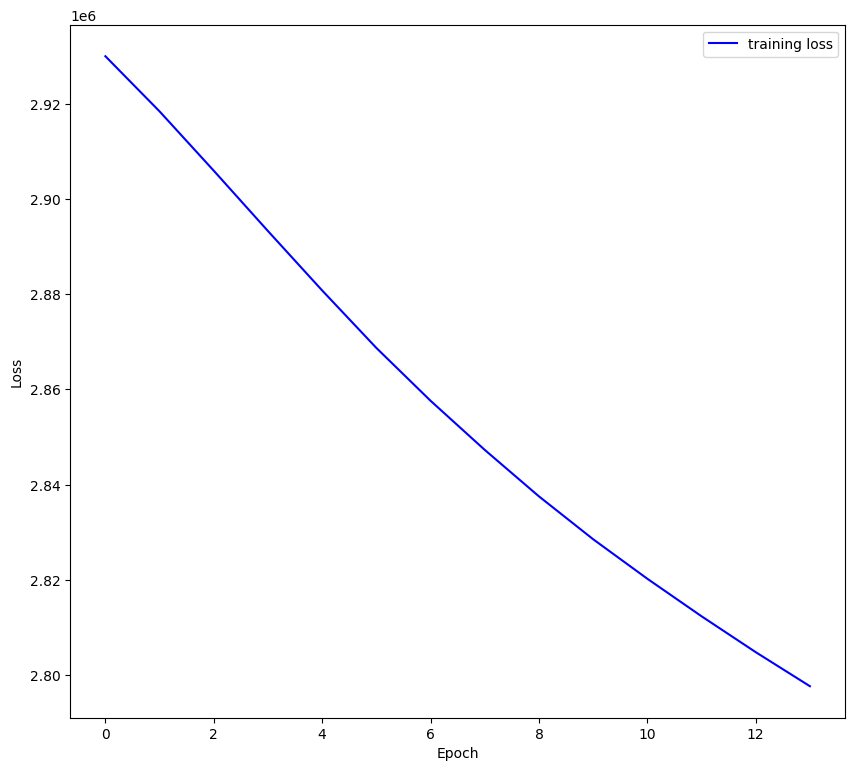

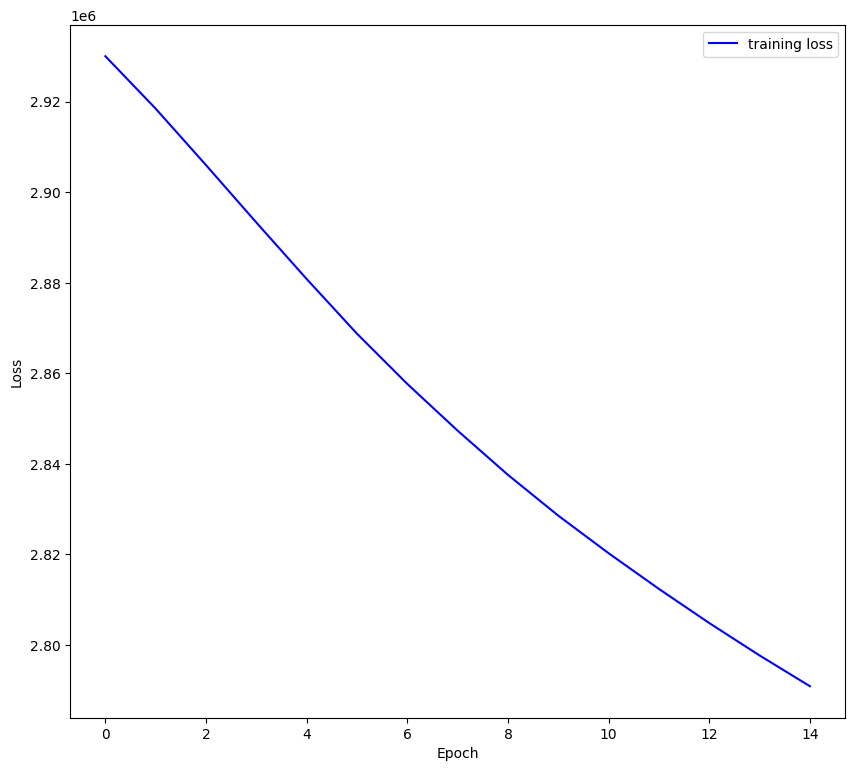

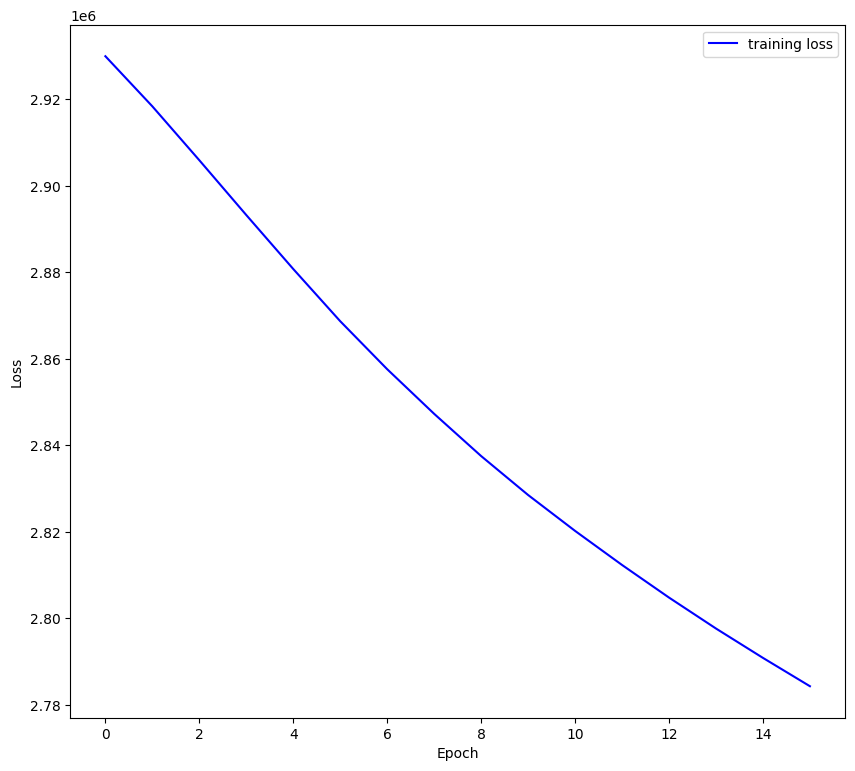

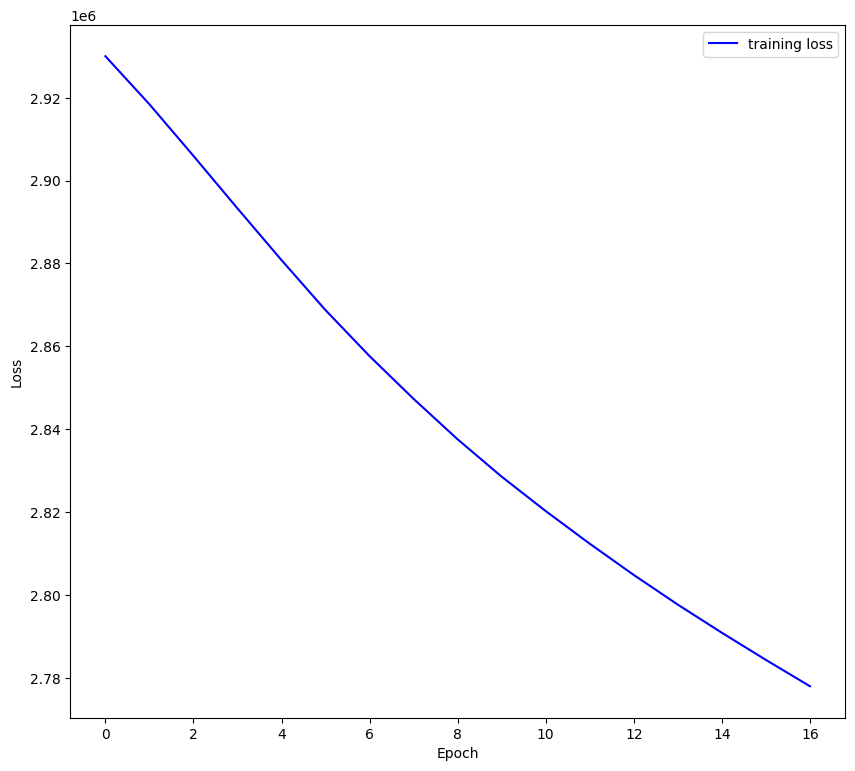

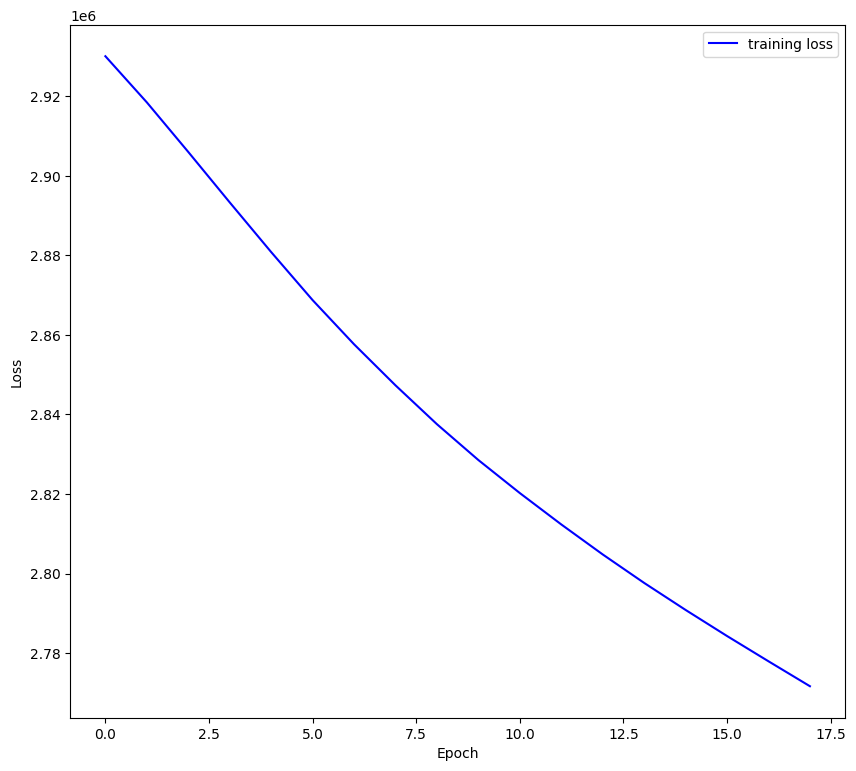

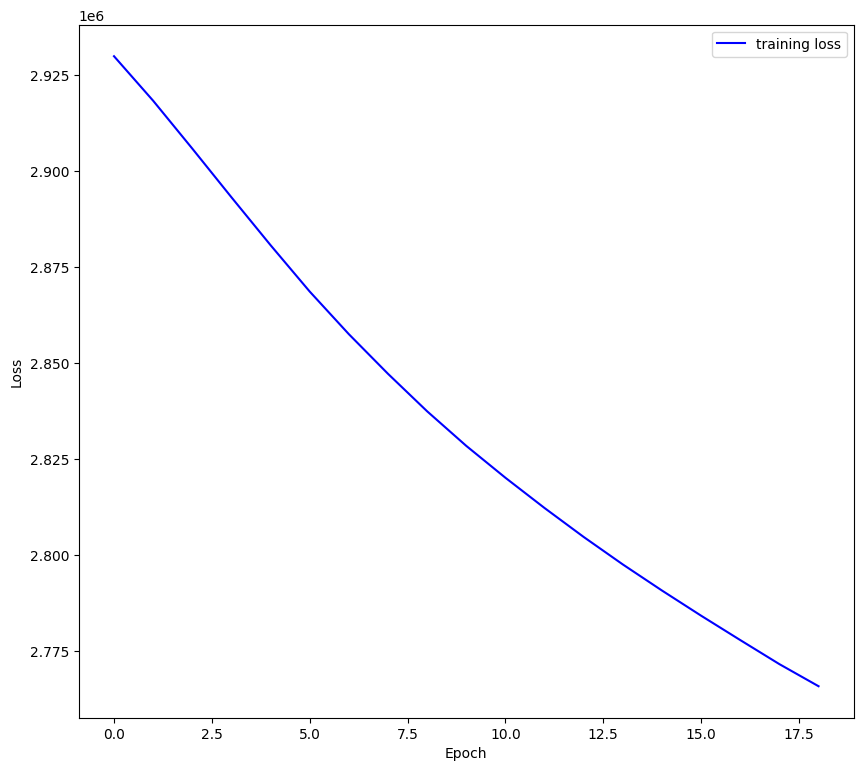

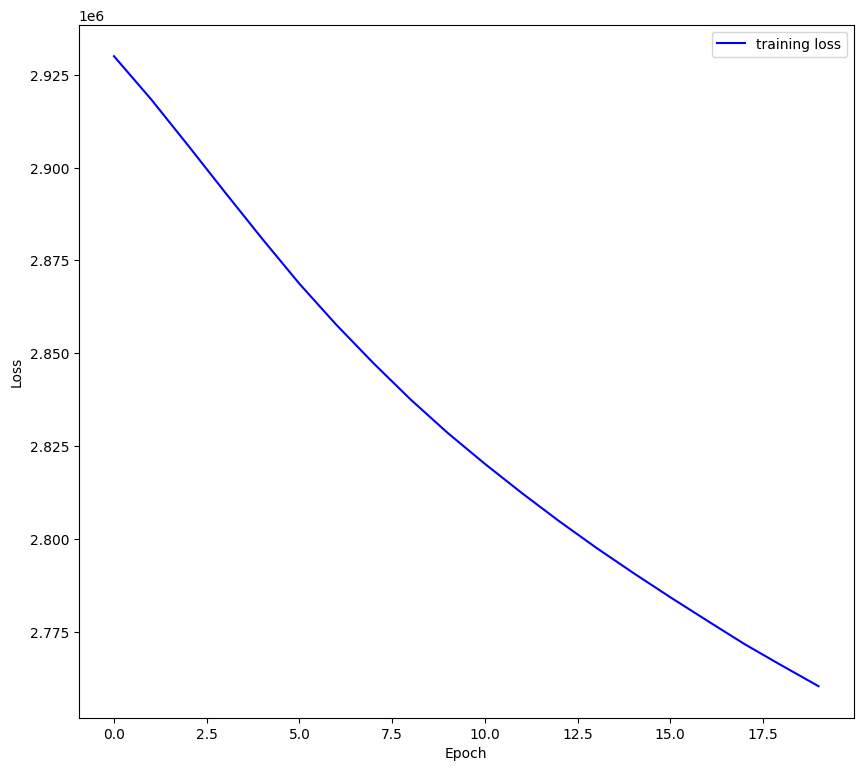

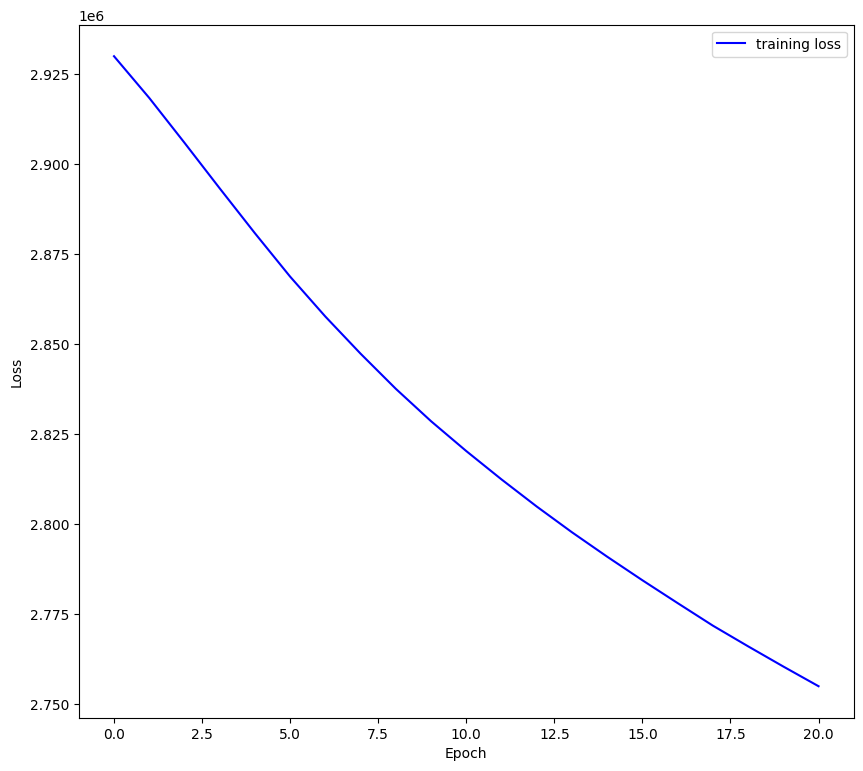

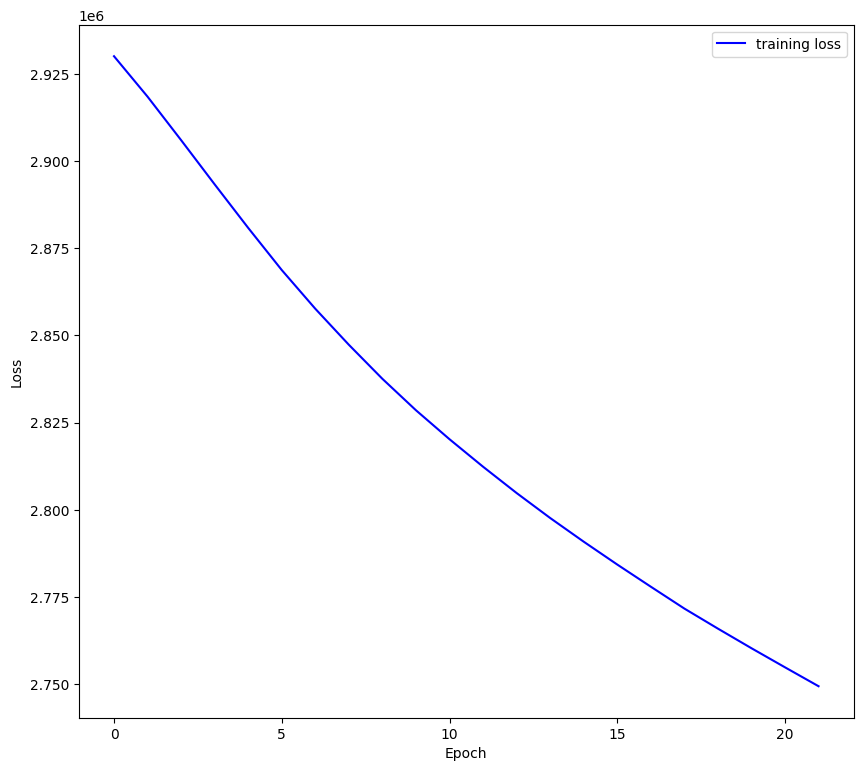

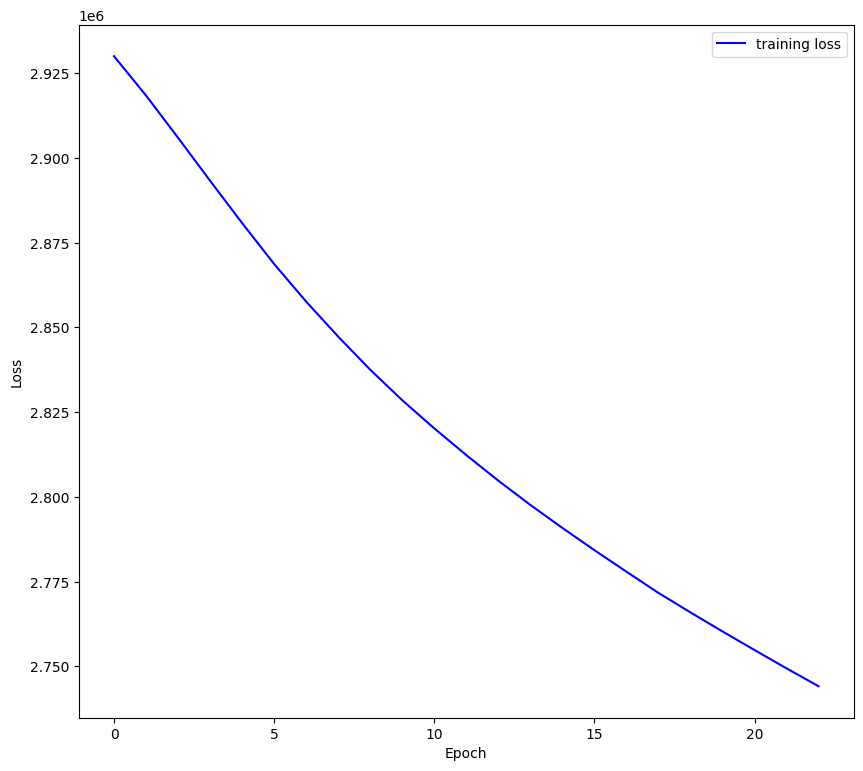

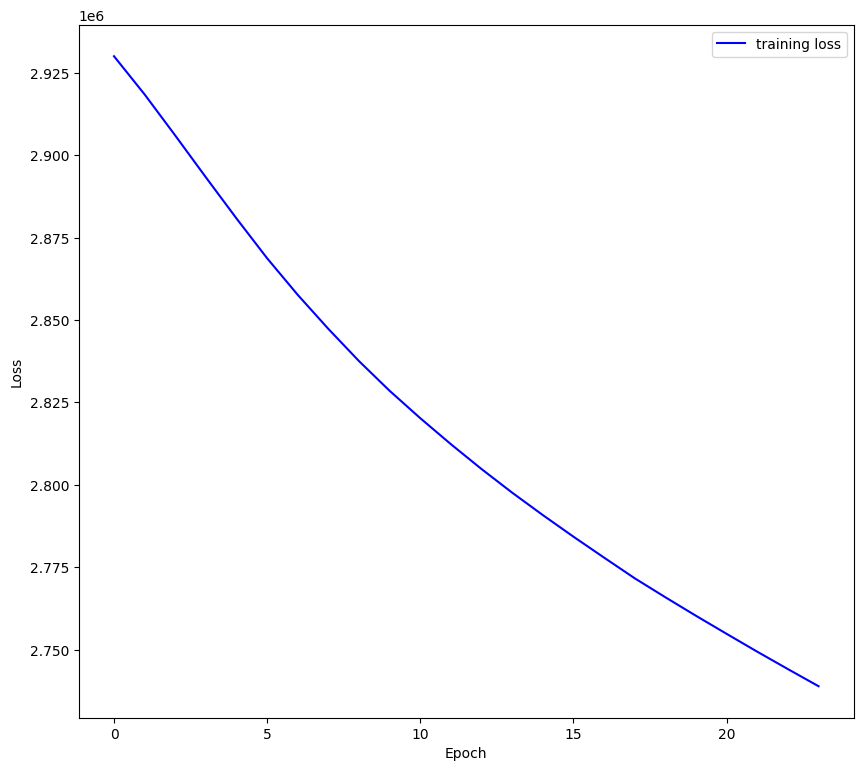

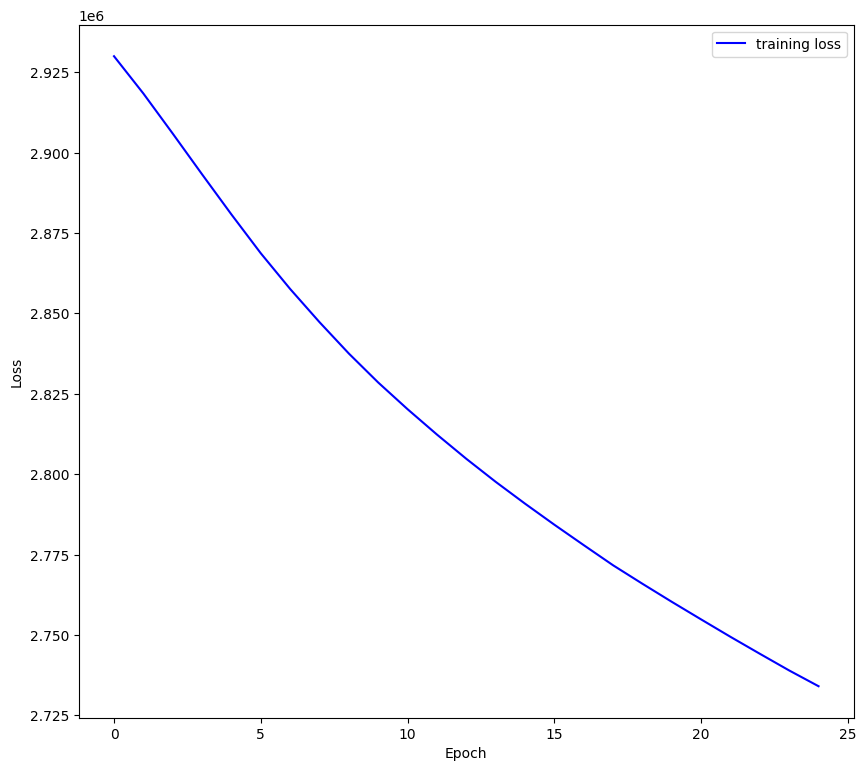

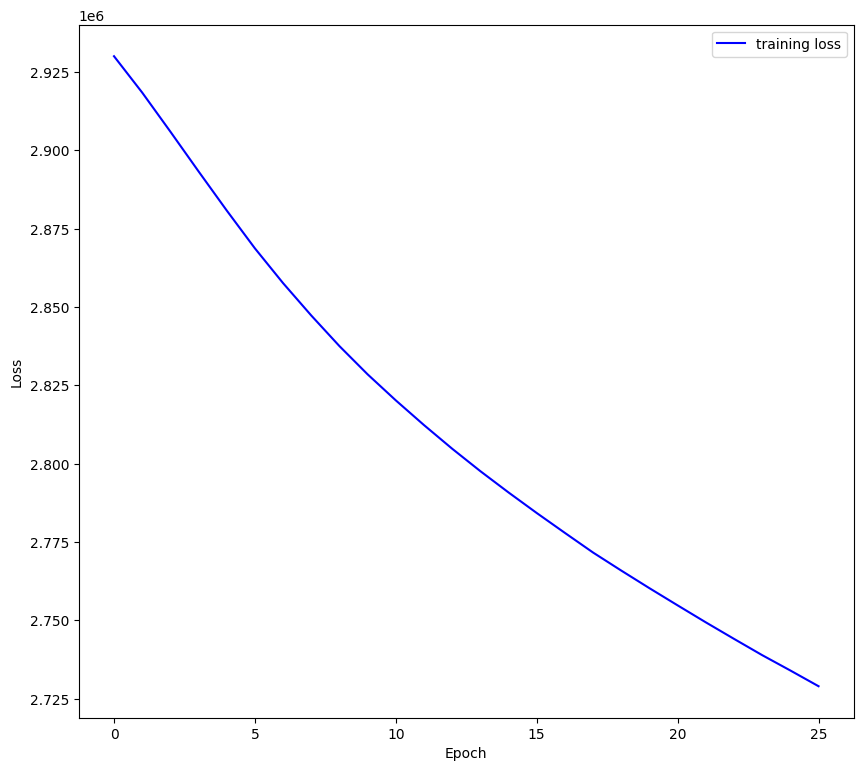

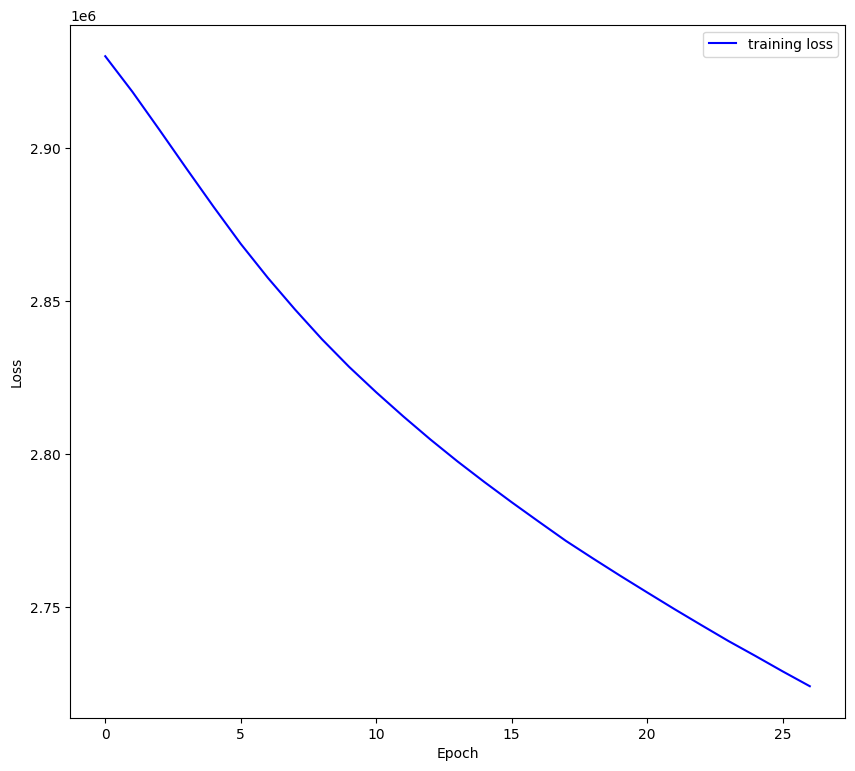

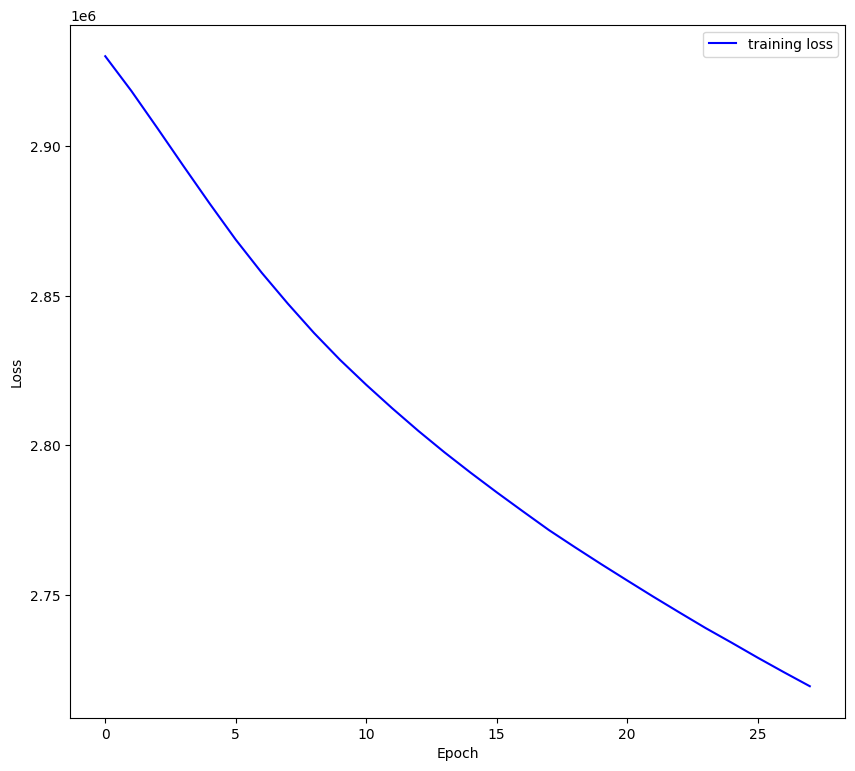

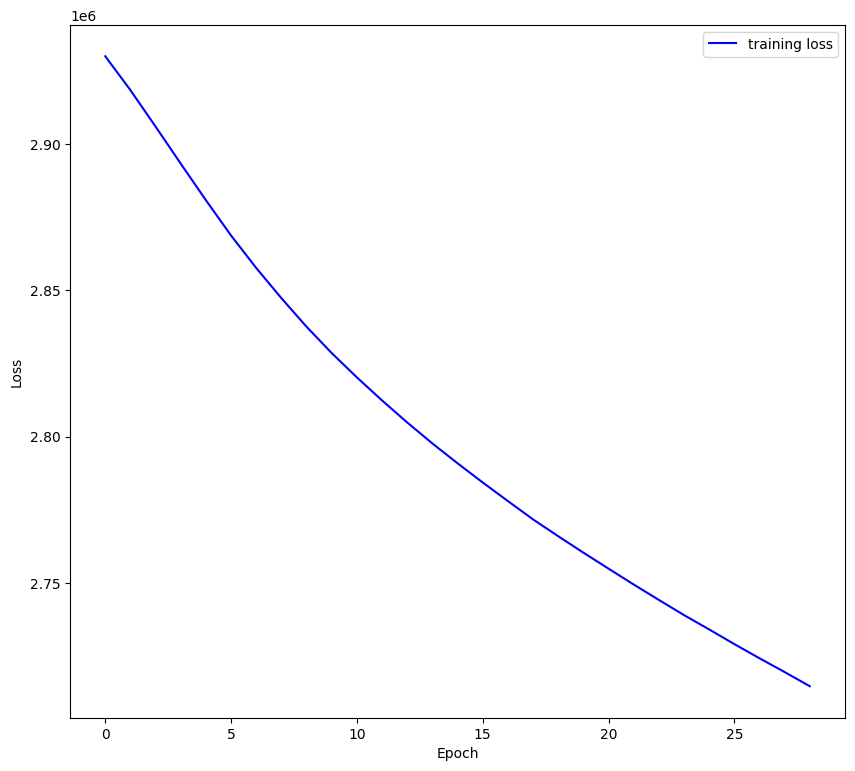

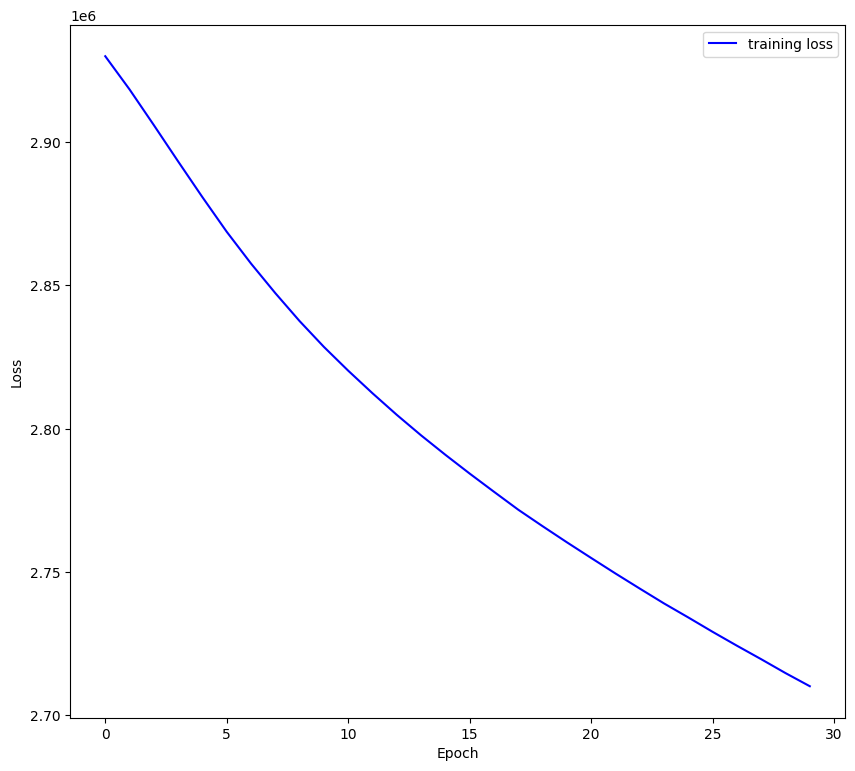

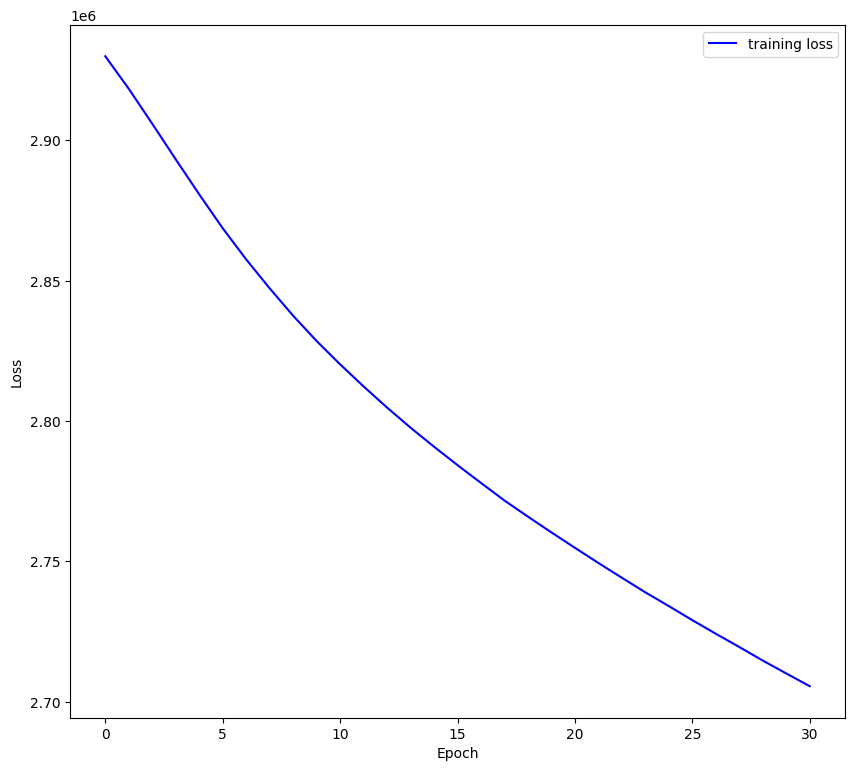

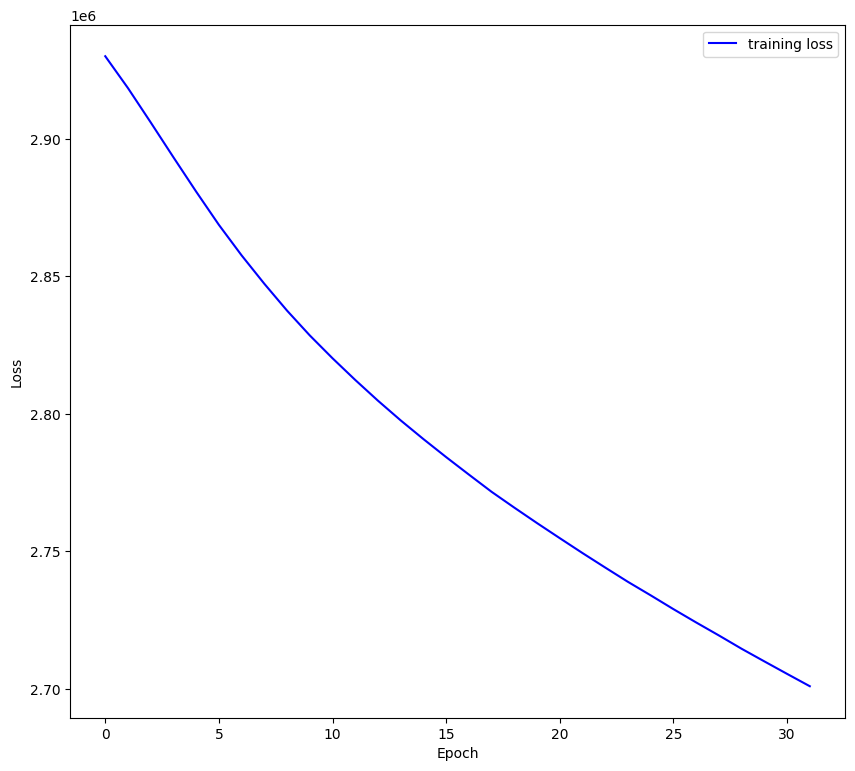

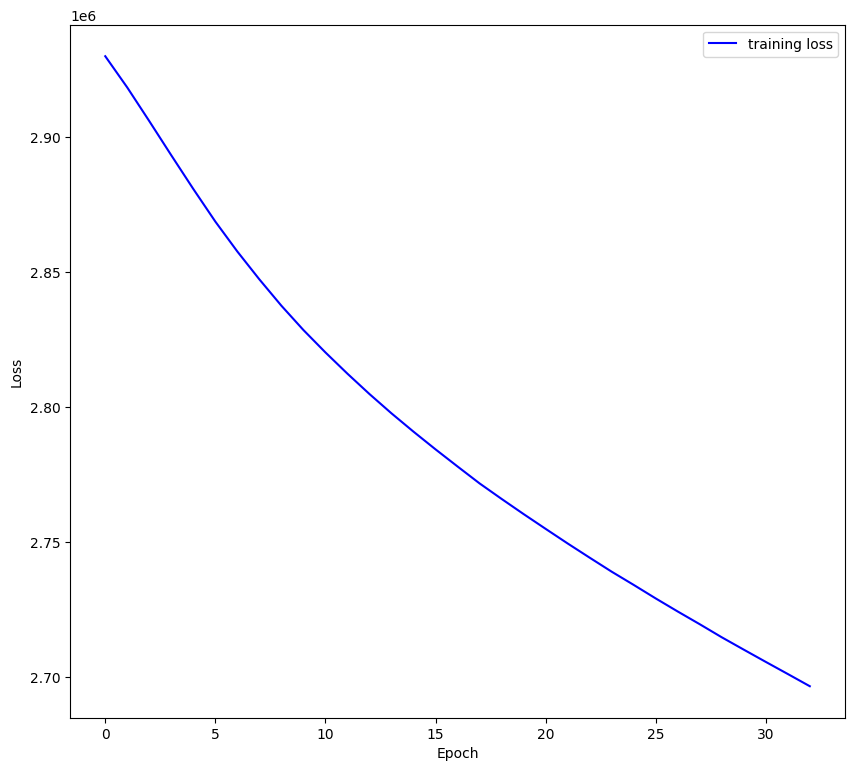

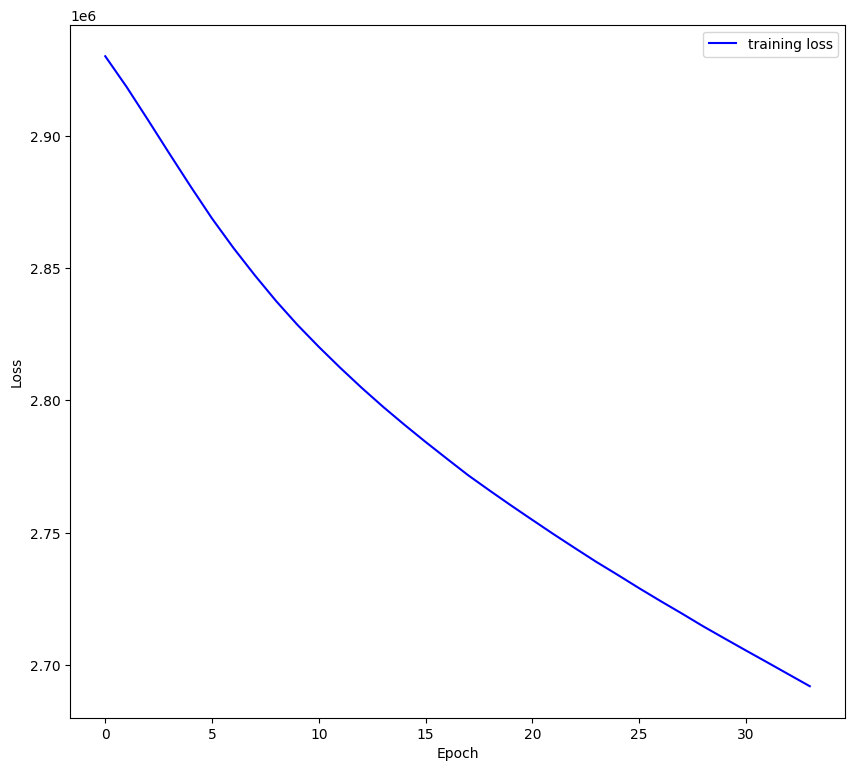

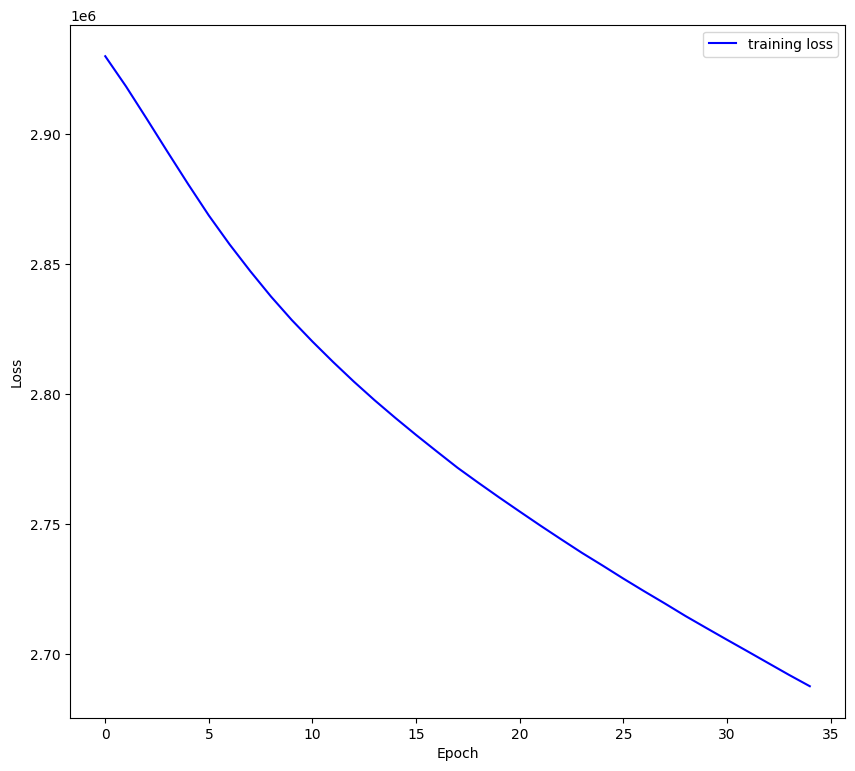

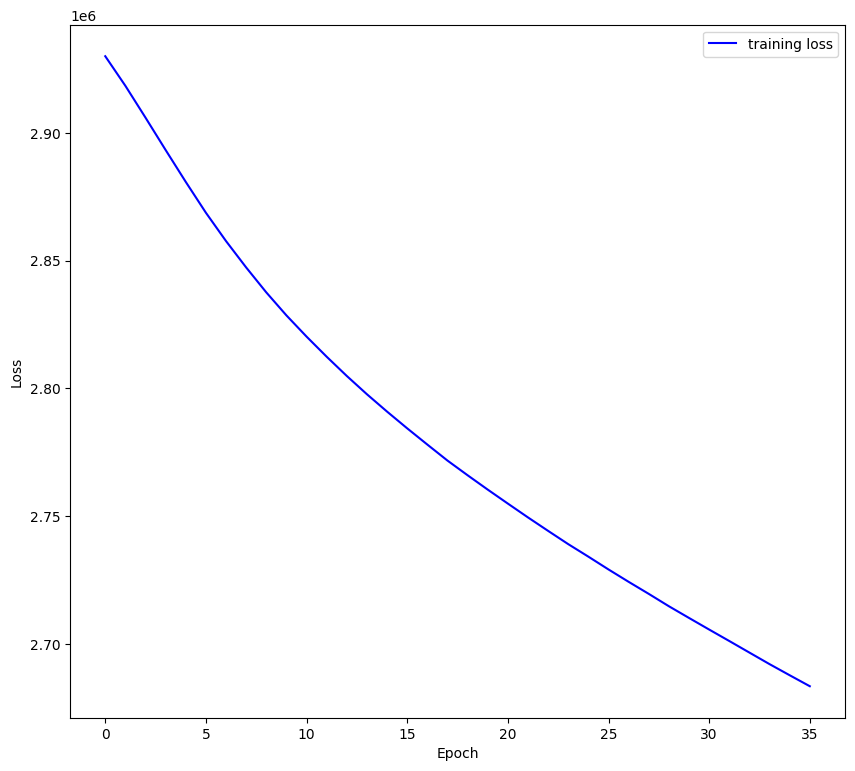

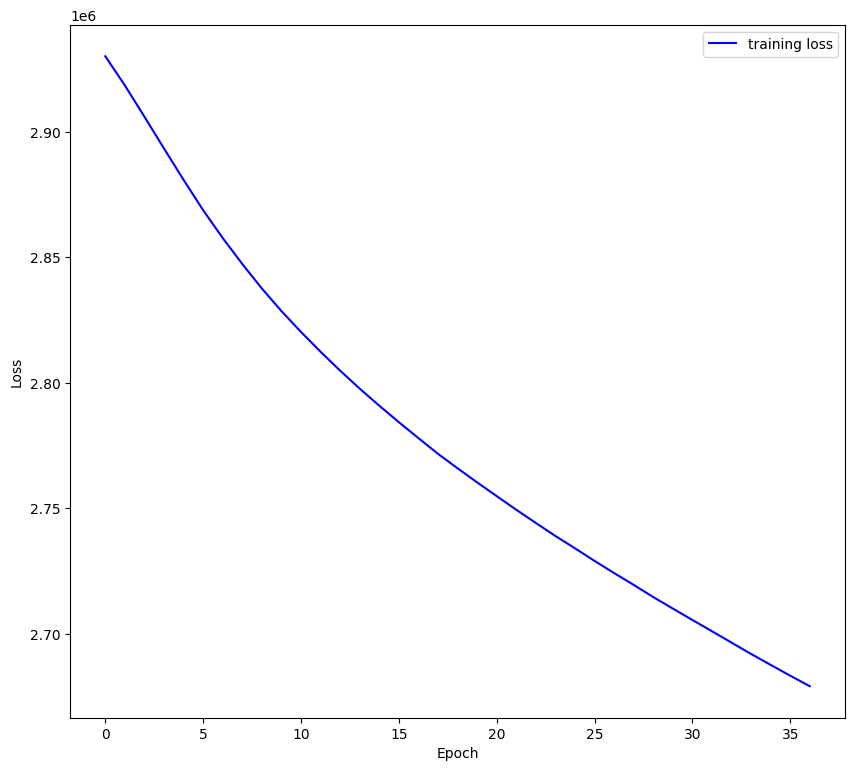

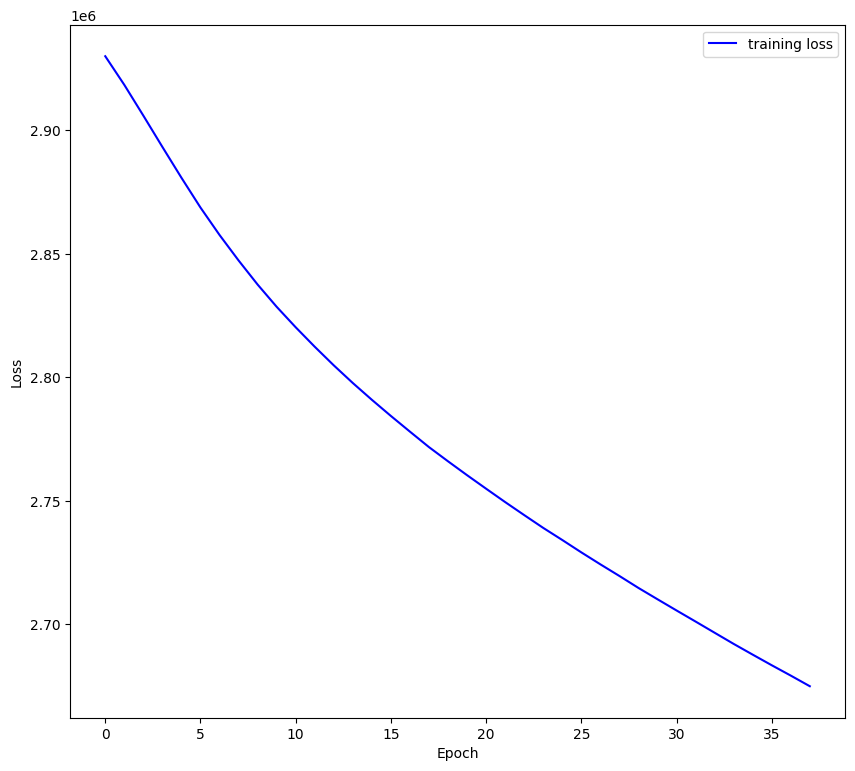

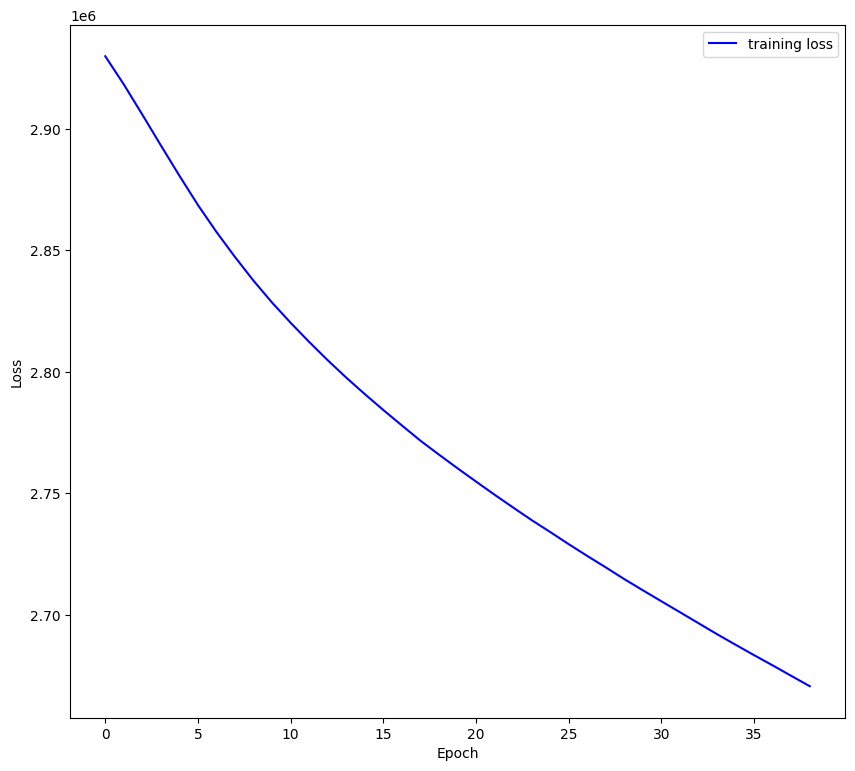

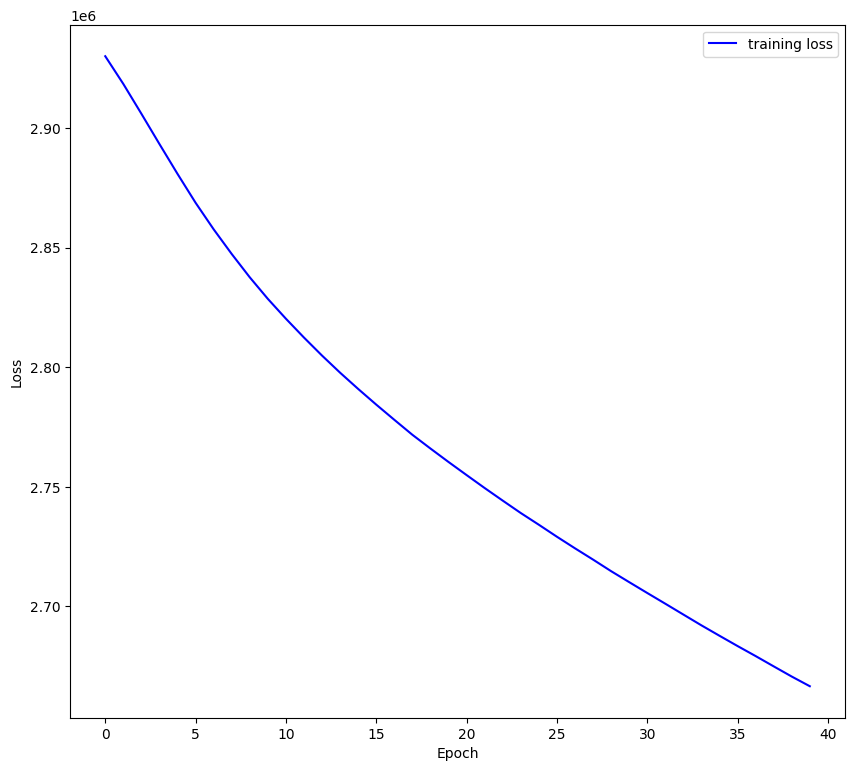

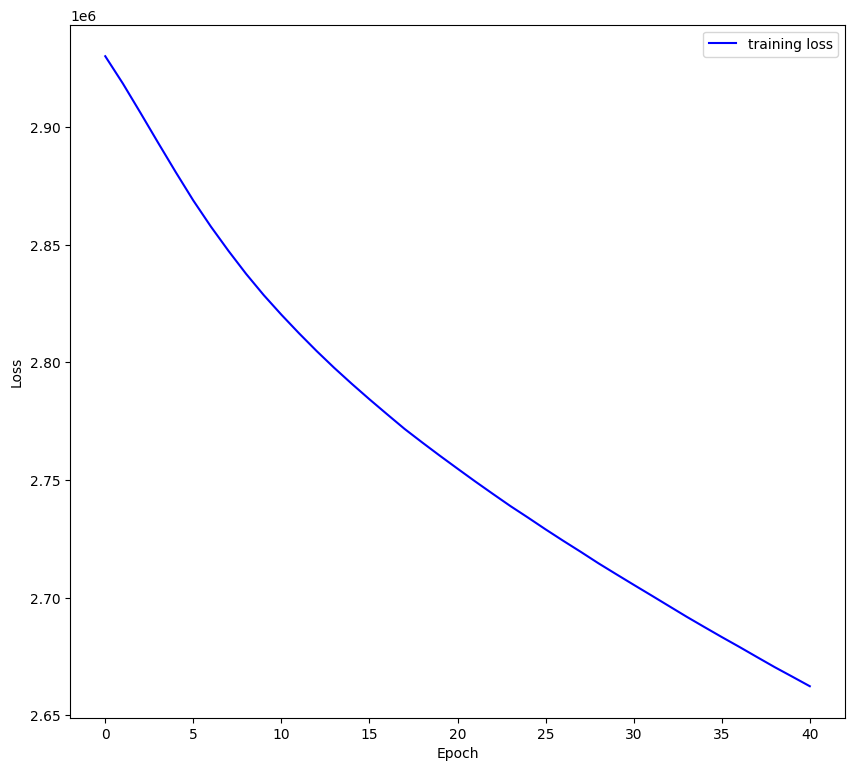

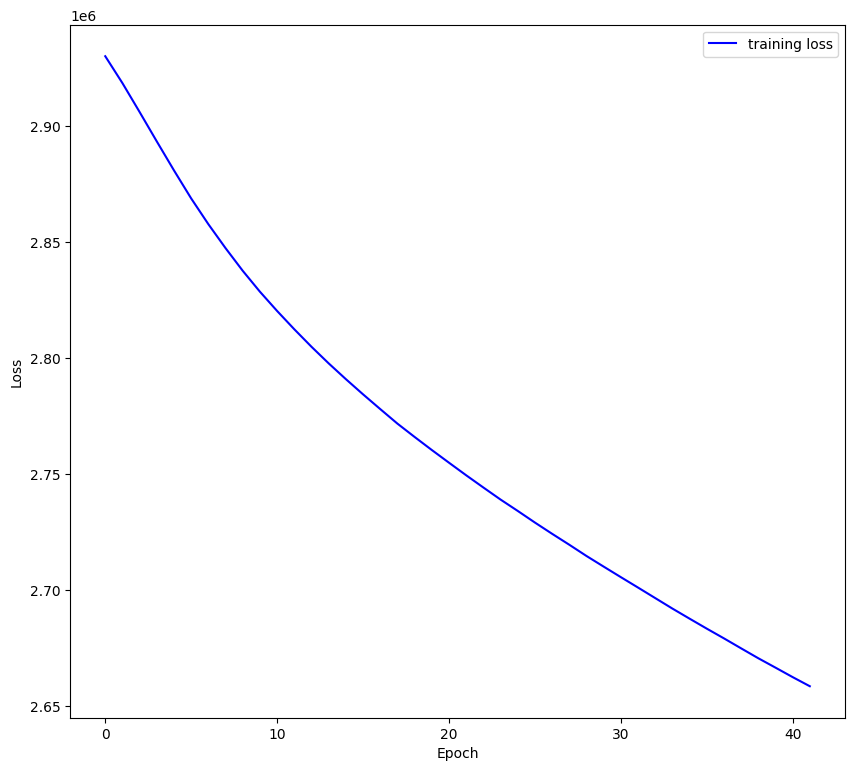

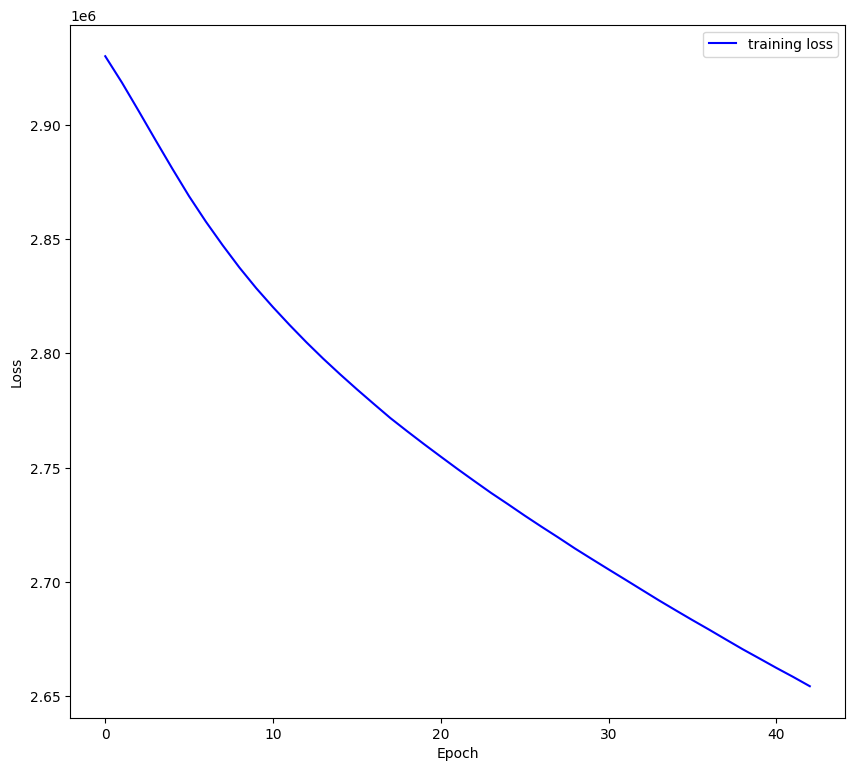

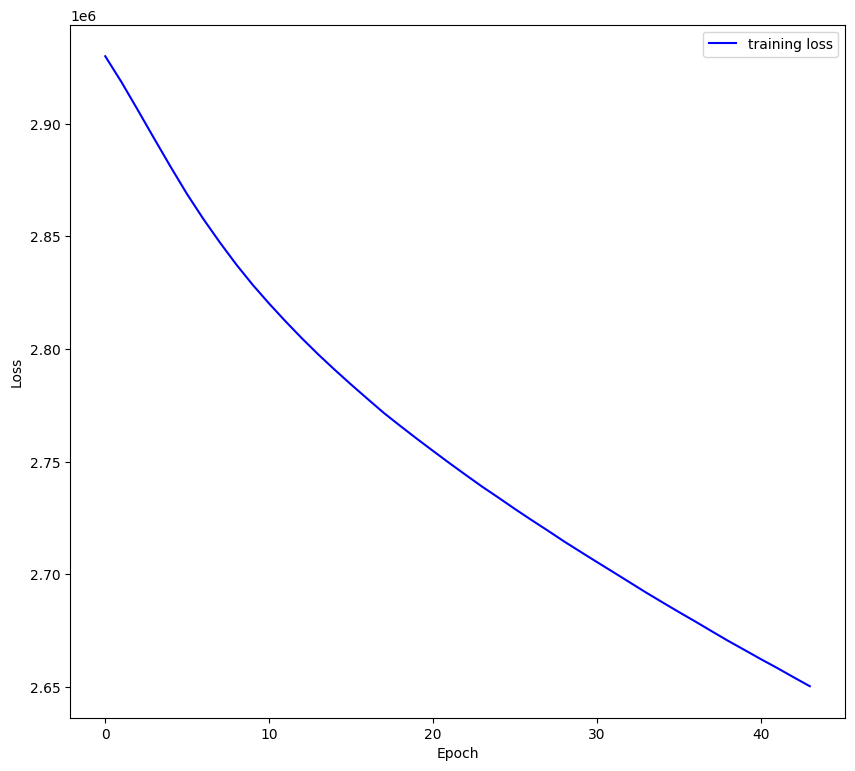

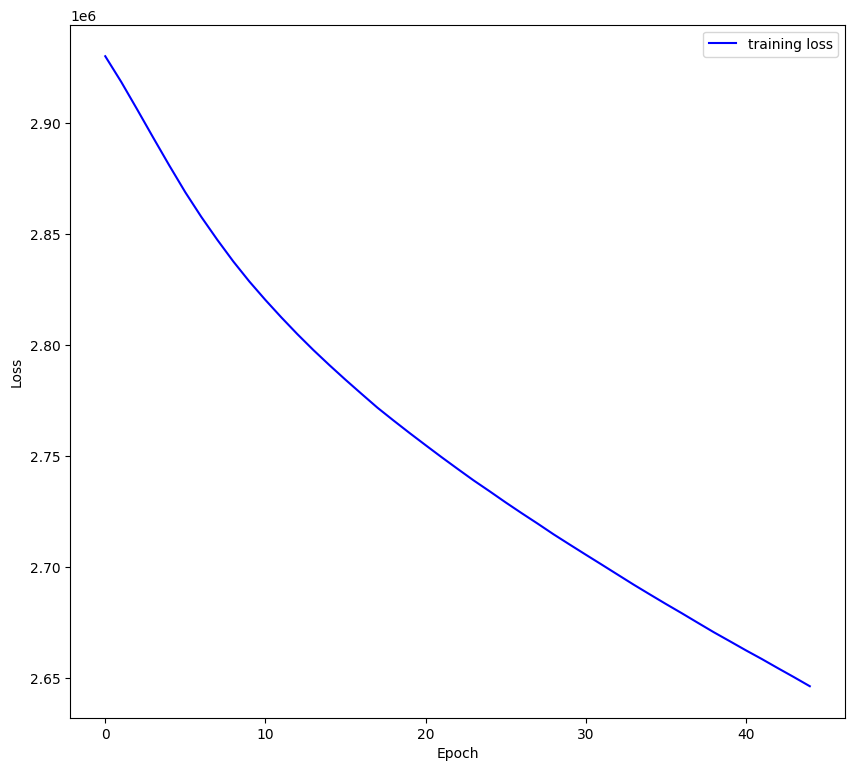

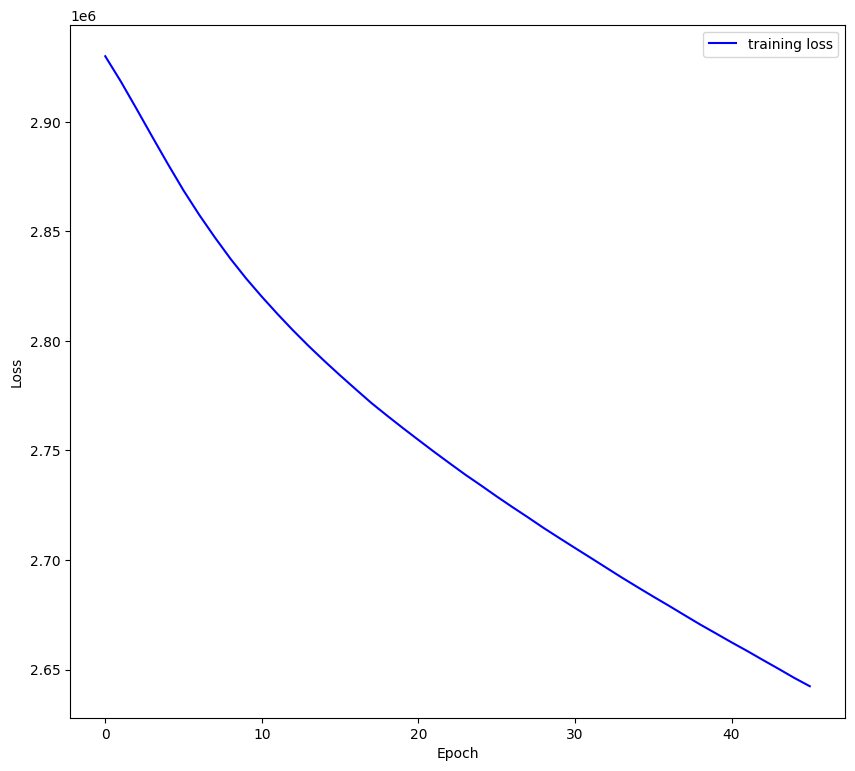

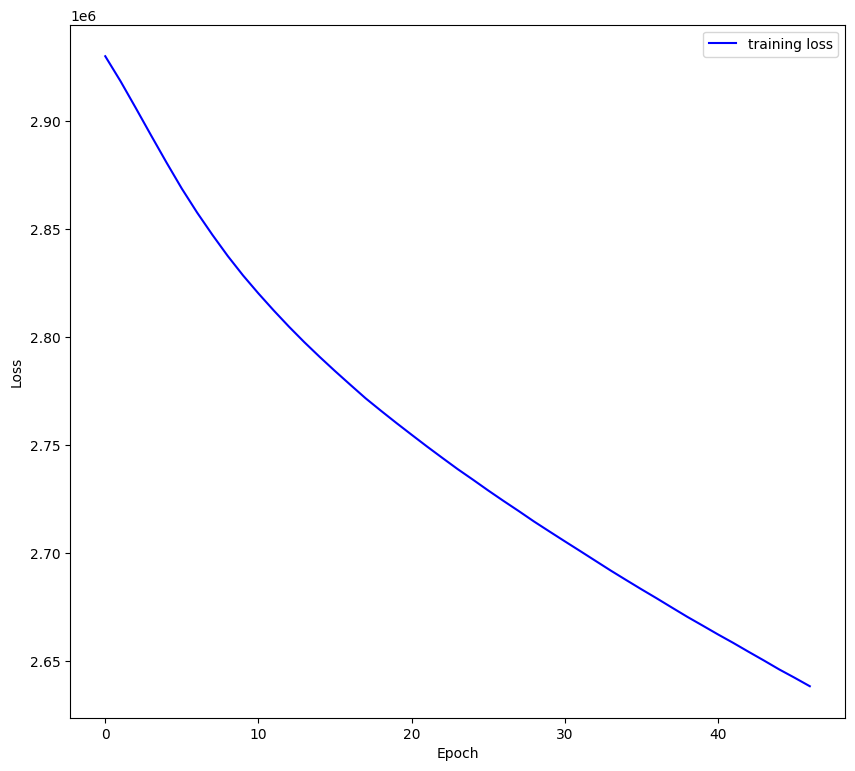

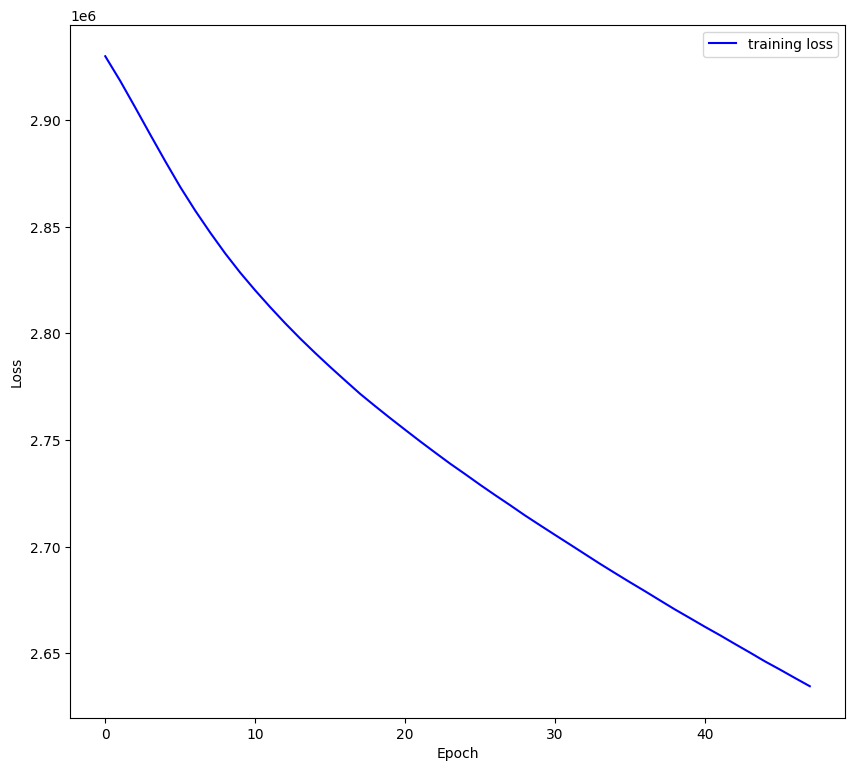

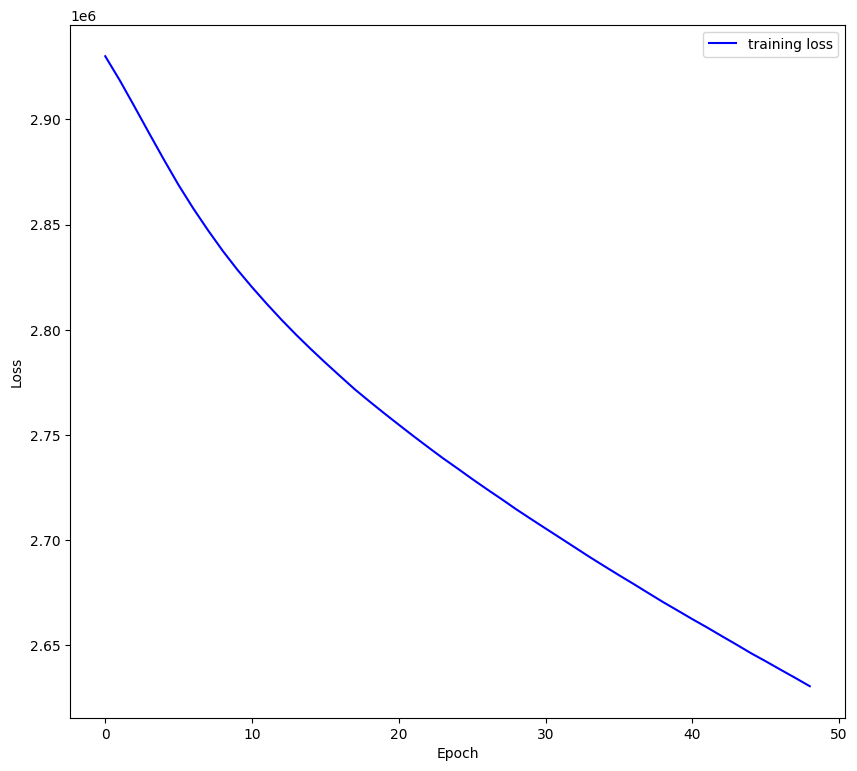

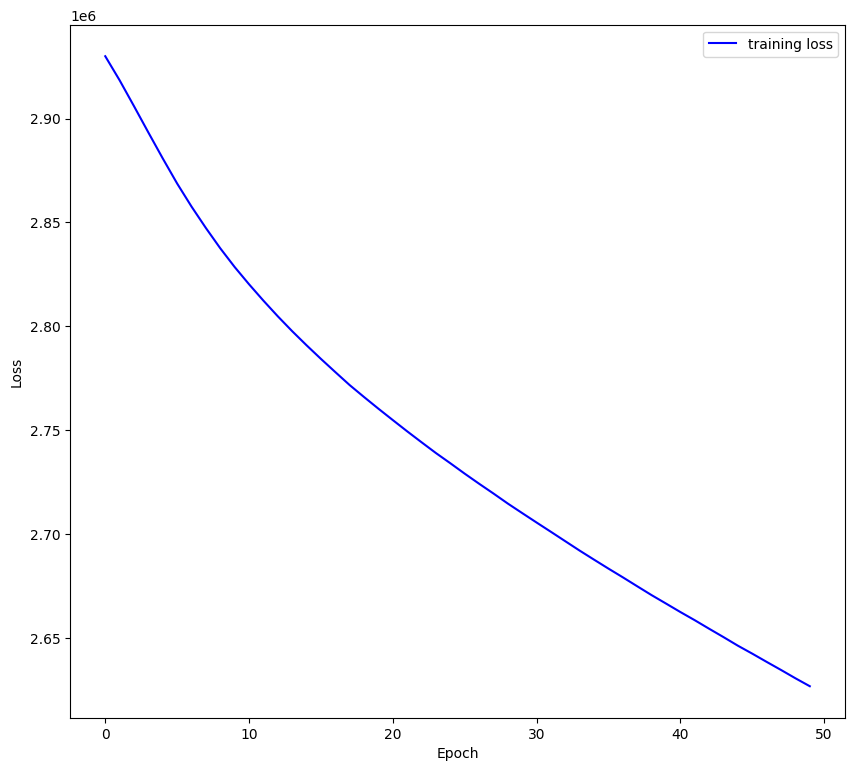

In [12]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)
for epoch in range(TRAIN_EPOCHS):
    train(net, optimizer, epoch)

## Evaluation

### Model Ensemble

In [14]:
def test_ensemble():
    net.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES+1, dtype=int)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            outputs[TEST_SAMPLES] = net(data, sample=False)
            output = outputs.mean(0)
            preds = preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1] # index of max log-probability
            corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
            correct += pred.eq(target.view_as(pred)).sum().item()
    for index, num in enumerate(corrects):
        if index < TEST_SAMPLES:
            print('Component {} Accuracy: {}/{}'.format(index, num, TEST_SIZE))
        else:
            print('Posterior Mean Accuracy: {}/{}'.format(num, TEST_SIZE))
    print('Ensemble Accuracy: {}/{}'.format(correct, TEST_SIZE))

net = torch.load("BayesBackprop_49_2626698.5.pth")
test_ensemble()

Component 0 Accuracy: 7377/10000
Component 1 Accuracy: 7370/10000
Component 2 Accuracy: 7388/10000
Component 3 Accuracy: 7414/10000
Component 4 Accuracy: 7385/10000
Component 5 Accuracy: 7418/10000
Component 6 Accuracy: 7370/10000
Component 7 Accuracy: 7406/10000
Component 8 Accuracy: 7339/10000
Component 9 Accuracy: 7372/10000
Posterior Mean Accuracy: 7467/10000
Ensemble Accuracy: 7465/10000


## Weight Distribution

torch.Size([500, 784])
torch.Size([500, 500])
torch.Size([10, 500])
torch.Size([500])
torch.Size([500])
torch.Size([10])
648010


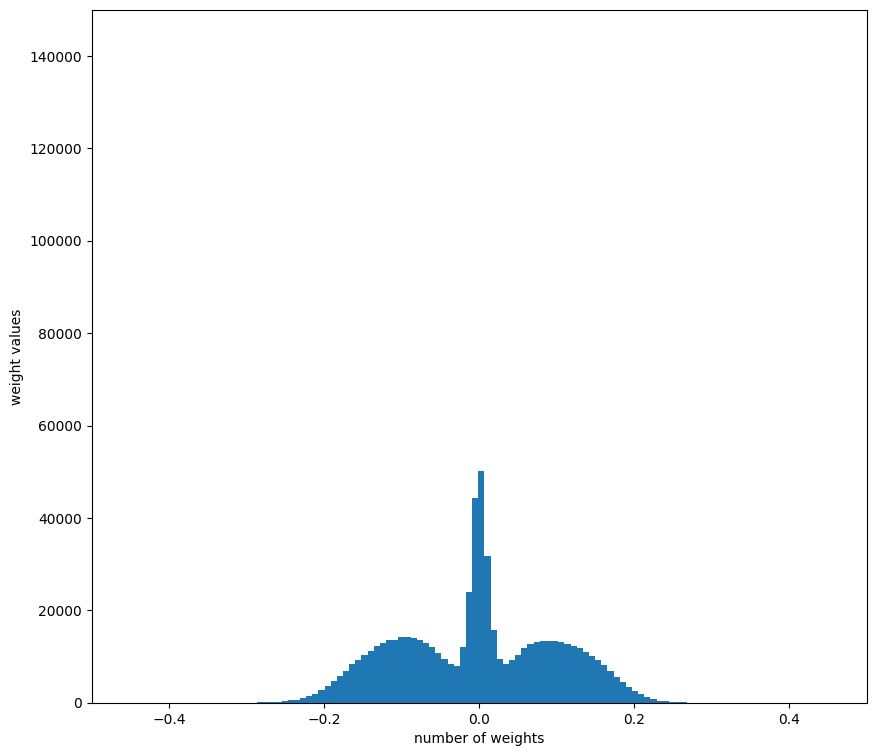

In [15]:
net = torch.load("BayesBackprop_49_2626698.5.pth")

weight1 = net.l1.weight.sample()
bias1 = net.l1.bias.sample()

weight2 = net.l2.weight.sample()
bias2 = net.l2.bias.sample()

weight3 = net.l3.weight.sample()
bias3 = net.l3.bias.sample()

params = [weight1, weight2, weight3, bias1, bias2, bias3]
all_params = []

for param in params:
    print(param.shape)
    tlist = torch.flatten(param.cpu()).tolist()
    all_params += tlist

print(len(all_params))

plt.figure(figsize=(10,9))
plt.hist(all_params, bins=100)
plt.ylabel('weight values')
plt.xlabel('number of weights')
plt.xlim(-0.5, 0.5)
plt.ylim(0, 150000)
plt.savefig(f'./{NAME}_weight dist.png')

## Pruning

In [28]:
def snr_pruning(ratio=0.5):
    all_snrs = []

    weightm1 = net.l1.weight_mu.clone()
    weightr1 = net.l1.weight_rho.clone()
    biasm1 = net.l1.bias_mu.clone()
    biasr1 = net.l1.bias_rho.clone()

    weightm2 = net.l2.weight_mu.clone()
    weightr2 = net.l2.weight_rho.clone()
    biasm2 = net.l2.bias_mu.clone()
    biasr2 = net.l2.bias_rho.clone()

    weightm3 = net.l3.weight_mu.clone()
    weightr3 = net.l3.weight_rho.clone()
    biasm3 = net.l3.bias_mu.clone()
    biasr3 = net.l3.bias_rho.clone()

    snrw1 = torch.abs(weightm1)/weightr1
    all_snrs += torch.flatten(snrw1).tolist()
    snrb1 = biasm1/biasr1
    all_snrs += torch.flatten(snrb1).tolist()

    snrw2 = torch.abs(weightm2)/weightr2
    all_snrs += torch.flatten(snrw2).tolist()
    snrb2 = biasm2/biasr2
    all_snrs += torch.flatten(snrb2).tolist()

    snrw3 = torch.abs(weightm3)/weightr3
    all_snrs += torch.flatten(snrw3).tolist()
    snrb3 = biasm3/biasr3
    all_snrs += torch.flatten(snrb3).tolist()

    all_snrs = sorted(all_snrs)
    idx = int(ratio*len(all_snrs))
    thresh = torch.tensor(all_snrs[idx]).cuda()
    zero = torch.tensor(0,dtype=torch.float32).cuda()

    print(torch.count_nonzero(net.l1.weight_mu))
    print(torch.count_nonzero(net.l1.weight_rho))
    print(torch.count_nonzero(net.l1.bias_mu))
    print(torch.count_nonzero(net.l1.bias_rho))
    net.l1.weight_mu = nn.Parameter(torch.where(snrw1 < thresh, zero, net.l1.weight_mu))
    net.l1.weight_rho = nn.Parameter(torch.where(snrw1 < thresh, zero, net.l1.weight_rho))
    net.l1.bias_mu = nn.Parameter(torch.where(snrb1 < thresh, zero, net.l1.bias_mu))
    net.l1.bias_rho = nn.Parameter(torch.where(snrb1 < thresh, zero, net.l1.bias_rho))
    print(torch.count_nonzero(net.l1.weight_mu))
    print(torch.count_nonzero(net.l1.weight_rho))
    print(torch.count_nonzero(net.l1.bias_mu))
    print(torch.count_nonzero(net.l1.bias_rho))

    net.l2.weight_mu = nn.Parameter(torch.where(snrw2 < thresh, zero, net.l2.weight_mu))
    net.l2.weight_rho = nn.Parameter(torch.where(snrw2 < thresh, zero, net.l2.weight_rho))
    net.l2.bias_mu = nn.Parameter(torch.where(snrb2 < thresh, zero, net.l2.bias_mu))
    net.l2.bias_rho = nn.Parameter(torch.where(snrb2 < thresh, zero, net.l2.bias_rho))

    net.l3.weight_mu = nn.Parameter(torch.where(snrw3 < thresh, zero, net.l3.weight_mu))
    net.l3.weight_rho = nn.Parameter(torch.where(snrw3 < thresh, zero, net.l3.weight_rho))
    net.l3.bias_mu = nn.Parameter(torch.where(snrb3 < thresh, zero, net.l3.bias_mu))
    net.l3.bias_rho = nn.Parameter(torch.where(snrb3 < thresh, zero, net.l3.bias_rho))



def test_ensemble():
    net.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES+1, dtype=int)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            outputs[TEST_SAMPLES] = net(data, sample=False)
            output = outputs.mean(0)
            preds = preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1] # index of max log-probability
            corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
            correct += pred.eq(target.view_as(pred)).sum().item()
    for index, num in enumerate(corrects):
        if index < TEST_SAMPLES:
            print('Component {} Accuracy: {}/{}'.format(index, num, TEST_SIZE))
        else:
            print('Posterior Mean Accuracy: {}/{}'.format(num, TEST_SIZE))
    print('Ensemble Accuracy: {}/{}'.format(correct, TEST_SIZE))

net = torch.load("BayesBackprop_49_2585582.5.pth")
snr_pruning(0.9)
test_ensemble()

tensor(392000, device='cuda:0')
tensor(392000, device='cuda:0')
tensor(500, device='cuda:0')
tensor(500, device='cuda:0')
tensor(38592, device='cuda:0')
tensor(38592, device='cuda:0')
tensor(256, device='cuda:0')
tensor(256, device='cuda:0')
Component 0 Accuracy: 8874/10000
Component 1 Accuracy: 8909/10000
Component 2 Accuracy: 8863/10000
Component 3 Accuracy: 8903/10000
Component 4 Accuracy: 8905/10000
Component 5 Accuracy: 8892/10000
Component 6 Accuracy: 8886/10000
Component 7 Accuracy: 8889/10000
Component 8 Accuracy: 8883/10000
Component 9 Accuracy: 8922/10000
Posterior Mean Accuracy: 8948/10000
Ensemble Accuracy: 8949/10000


### Model Uncertainty

#### In-Domain Uncertainty

In [ ]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

tensor([ 9,  2,  1,  1,  6])


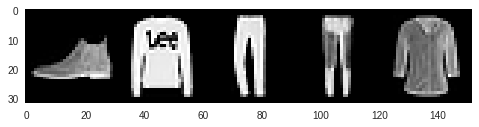

In [14]:
fmnist_sample = iter(test_loader).next()
fmnist_sample[0] = fmnist_sample[0].to(DEVICE)
print(fmnist_sample[1])
sns.set_style("dark")
show(make_grid(fmnist_sample[0].cpu()))

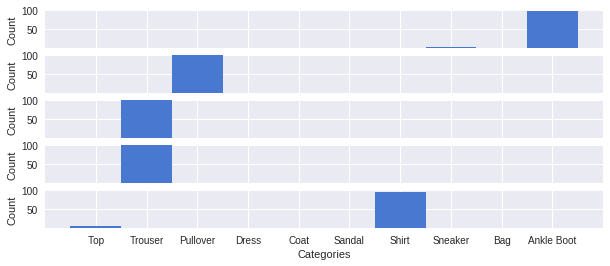

In [15]:
net.eval()
fmnist_outputs = net(fmnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy()
for _ in range(99):
    fmnist_outputs = np.append(fmnist_outputs, net(fmnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy(), axis=1)
sns.set_style("darkgrid")
plt.subplots(5,1,figsize=(10,4))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.ylim(0,100)
    plt.xlabel("Categories")
    plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.ylabel("Count")
    plt.yticks(range(50,101,50))
    plt.hist(fmnist_outputs[i], np.arange(-0.5, 10, 1))

#### Out-of-Domain Uncertainty

In [ ]:
mnist_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist', train=False, download=True, transform=transforms.ToTensor()), batch_size=5, shuffle=False)

tensor([ 7,  2,  1,  0,  4])


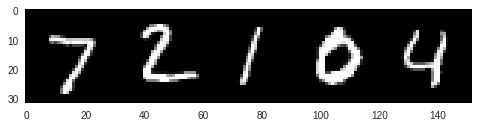

In [17]:
mnist_sample = iter(mnist_loader).next()
mnist_sample[0] = mnist_sample[0].to(DEVICE)
print(mnist_sample[1])
sns.set_style("dark")
show(make_grid(mnist_sample[0].cpu()))

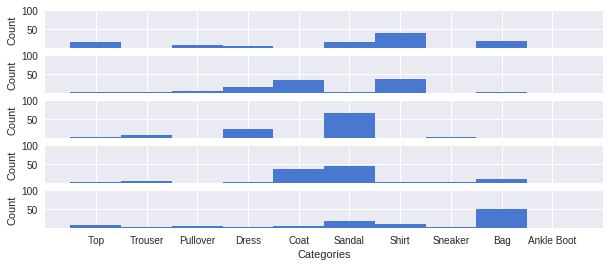

In [18]:
net.eval()
mnist_outputs = net(mnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy()
for _ in range(99):
    mnist_outputs = np.append(mnist_outputs, net(mnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy(), axis=1)

sns.set_style("darkgrid")
plt.subplots(5,1,figsize=(10,4))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.ylim(0,100)
    plt.xlabel("Categories")
    plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.ylabel("Count")
    plt.yticks(range(50,101,50))
    plt.hist(mnist_outputs[i], np.arange(-0.5, 10, 1))

In [19]:
%load_ext watermark
%watermark --updated --datename --python --machine --watermark -p torch,numpy,matplotlib,tensorboardX,torchvision,seaborn

last updated: Wed Jun 06 2018 

CPython 3.6.3
IPython 5.5.0

torch 0.4.0
numpy 1.14.3
matplotlib 2.1.2
tensorboardX n
torchvision 0.2.1
seaborn 0.7.1

compiler   : GCC 7.2.0
system     : Linux
release    : 4.4.111+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
watermark 1.6.0
